## Segmentation des clients du site E-Commerce Olist - Notebook Essais
Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication. L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps (dans le but d'établir un contrat de maintenance -cf. notebook simulation).


## Sommaire

1. Cluatering avec RFM Manuel
2. Clustering avec l'algorithme du K-Means (RFM seulement, RFM avec quelques variables, Toutes les variables, Toutes les variables sans les catégories de produits)
3. K-Means après réduction de dimensions
4. Clustering Hierarchique
5. Clustering DBscan

### Importation des librairies utiles

In [1]:
# Standards Librairies import
%matplotlib inline
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

# Preprocessing and pipeline librairies
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

#Modelling and model evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes

In [2]:
df = pd.read_csv("olist-customers-segmentation.csv",
                   index_col=0)
df=df.drop(columns=['index'])
df.head()

customer_unique_id  nb_orders  distance_seller_customer  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1                110.568636   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1                 22.168333   
2  0000f46a3911fa3c0805444483337064          1                516.938836   
3  0000f6ccb0745a6a4b88665a16c9f078          1               2481.287188   
4  0004aac84e0df4da2b147fca70cf8255          1                154.507887   

   mean_product_volume_cm3  mean_payment_installments  mean_review_score  \
0                   7616.0                        8.0                5.0   
1                   5148.0                        1.0                4.0   
2                  43750.0                        8.0                3.0   
3                   1045.0                        4.0                4.0   
4                    528.0                        6.0                5.0   

   mean_delivery_days  favorite_sale_month order_purchase_timestamp  \
0                 6.0                    5      2018-05-10 10:56:27   
1                 3.0                    5      2018-05-07 11:11:27   
2                26.0                    3      2017-03-10 21:05:03   
3                20.0                   10      2017-10-12 20:29:41   
4                13.0                   11      2017-11-14 19:45:42   

         dernier_achat  ... home_furniture  other  sport  technology  \
0  2018-05-10 10:56:27  ...            1.0    0.0    0.0         0.0   
1  2018-05-07 11:11:27  ...            0.0    0.0    0.0         0.0   
2  2017-03-10 21:05:03  ...            0.0    1.0    0.0         0.0   
3  2017-10-12 20:29:41  ...            0.0    0.0    0.0         1.0   
4  2017-11-14 19:45:42  ...            0.0    0.0    0.0         1.0   

   toys_baby  total_items  order_mean_delay  freight_ratio  mean_price_order  \
0        0.0          1.0             111.0           0.08            141.90   
1        0.0          1.0             114.0           0.23             27.19   
2        0.0          1.0             537.0           0.17             86.22   
3        0.0          1.0             321.0           0.29             43.62   
4        0.0          1.0             288.0           0.08            196.89   

   customer_state  
0       São Paulo  
1       São Paulo  
2  Santa Catarina  
3            Pará  
4       São Paulo  

[5 rows x 26 columns]

In [3]:
df.columns

Index(['customer_unique_id', 'nb_orders', 'distance_seller_customer',
       'mean_product_volume_cm3', 'mean_payment_installments',
       'mean_review_score', 'mean_delivery_days', 'favorite_sale_month',
       'order_purchase_timestamp', 'dernier_achat', 'payment_type',
       'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
       'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
       'sport', 'technology', 'toys_baby', 'total_items', 'order_mean_delay',
       'freight_ratio', 'mean_price_order', 'customer_state'],
      dtype='object')

# Clustering avec RFM manuel

- Recency : order_mean_delay

Combien de temps s'est écoulé depuis la dernière activité ou transaction d'un client avec la marque ? L'activité est généralement un achat. Plus un client a récemment interagi ou effectué des transactions avec une marque, plus il est probable que le client répondra aux communications de la marque.

La récence est simplement le temps écoulé depuis la transaction la plus récente du client (la plupart des entreprises utilisent des jours, bien que pour d'autres, il peut être judicieux d'utiliser des mois, des semaines ou même des heures à la place).


- Frequency : nb_orders

À quelle fréquence un client a-t-il effectué des transactions ou interagi avec la marque au cours d'une période donnée ? De toute évidence, les clients ayant des activités fréquentes sont plus engagés, et probablement plus fidèles, que les clients qui le font rarement. Et les clients ponctuels sont dans une classe à part.

La fréquence est le nombre total de transactions effectuées par le client (pendant une période définie).

- Monetary : mean_price_order

Également appelé « valeur monétaire », ce facteur reflète le montant qu'un client a dépensé pour la marque au cours d'une période donnée. Les gros dépensiers devraient généralement être traités différemment des clients qui dépensent peu. Le fait de diviser la valeur monétaire par la fréquence indique le montant d'achat moyen - un facteur secondaire important à prendre en compte lors de la segmentation des clients.

Monétaire est le montant total que le client a dépensé pour toutes les transactions (pendant une période définie).

In [4]:
rfm=df.copy()

### Find Recency, Monetary and Frequency

In [5]:
rfm.columns

Index(['customer_unique_id', 'nb_orders', 'distance_seller_customer',
       'mean_product_volume_cm3', 'mean_payment_installments',
       'mean_review_score', 'mean_delivery_days', 'favorite_sale_month',
       'order_purchase_timestamp', 'dernier_achat', 'payment_type',
       'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
       'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
       'sport', 'technology', 'toys_baby', 'total_items', 'order_mean_delay',
       'freight_ratio', 'mean_price_order', 'customer_state'],
      dtype='object')

In [6]:
rfm.drop([ 'distance_seller_customer',
       'mean_product_volume_cm3', 'mean_payment_installments',
       'mean_review_score', 'mean_delivery_days', 'favorite_sale_month',
       'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
       'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
       'sport', 'technology', 'toys_baby', 'total_items','payment_type',
       'freight_ratio', 'customer_state','order_purchase_timestamp','dernier_achat'], axis=1, inplace=True)
rfm.head()

customer_unique_id  nb_orders  order_mean_delay  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1             111.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1             114.0   
2  0000f46a3911fa3c0805444483337064          1             537.0   
3  0000f6ccb0745a6a4b88665a16c9f078          1             321.0   
4  0004aac84e0df4da2b147fca70cf8255          1             288.0   

   mean_price_order  
0            141.90  
1             27.19  
2             86.22  
3             43.62  
4            196.89

### RFM Segmentation

Les consommateurs avec la récence la plus basse, la fréquence la plus élevée et le montant le montant le plus élevé sont considérés comme étant les Top Customers.

In [7]:
rfm=rfm.rename(columns={"nb_orders": "Frequency", "mean_price_order": "Monetary","order_mean_delay":"Recency"})

In [8]:
#Calcul du Fscore
def FScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

In [9]:
quantiles = rfm.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
rfm['Freq_Tile'] = rfm['Frequency'].apply(FScore, args=('Frequency',quantiles,))

#Recency 
rfm = rfm.sort_values('Recency',ascending=True)
rfm['Rec_Tile'] = pd.qcut(rfm['Recency'],5,labels=False)

#Monetary 
rfm['Mone_Tile'] = pd.qcut(rfm['Monetary'],5,labels=False)

# instead of zero, plus 1 
rfm['Rec_Tile'] = rfm['Rec_Tile'] + 1
rfm['Freq_Tile'] = rfm['Freq_Tile'] + 1
rfm['Mone_Tile'] = rfm['Mone_Tile'] + 1

# Add to dataframe
rfm['RFM Score'] = rfm['Rec_Tile'].map(str) + rfm['Freq_Tile'].map(str) + rfm['Mone_Tile'].map(str)
rfm.head()

customer_unique_id  Frequency  Recency  Monetary  \
96744  d77aa95864ae5b42160937615628723a          2      0.0   1225.05   
19931  2ca8ef8560c5cd0f9ddb65d1b1b51380          2      0.0    103.36   
28152  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   
28153  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   
28154  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   

       Freq_Tile  Rec_Tile  Mone_Tile RFM Score  
96744          5         1          5       155  
19931          5         1          3       153  
28152          5         1          5       155  
28153          5         1          5       155  
28154          5         1          5       155

Qui sont mes meilleurs clients ?


In [11]:
rfm[rfm['RFM Score'] == rfm['RFM Score'].max()].sort_values('Monetary', ascending=False).head()

customer_unique_id  Frequency  Recency  Monetary  \
88254  c4b224d2c784bae11ae98b6ae9f2454c          1    457.0   11111.4   
88260  c4b224d2c784bae11ae98b6ae9f2454c          1    457.0   11111.4   
88249  c4b224d2c784bae11ae98b6ae9f2454c          1    457.0   11111.4   
88248  c4b224d2c784bae11ae98b6ae9f2454c          1    457.0   11111.4   
88251  c4b224d2c784bae11ae98b6ae9f2454c          1    457.0   11111.4   

       Freq_Tile  Rec_Tile  Mone_Tile RFM Score  
88254          1         5          5       515  
88260          1         5          5       515  
88249          1         5          5       515  
88248          1         5          5       515  
88251          1         5          5       515

Les clients à risque ? 

In [12]:
#Customers who's recency value is low
rfm[rfm['Rec_Tile'] <= 2 ].sort_values('Monetary', ascending=False).head()

customer_unique_id  Frequency  Recency  Monetary  \
85415  be74c431147c32ab2d7c7cef5e4a995f          1    111.0  10055.22   
85412  be74c431147c32ab2d7c7cef5e4a995f          1    111.0  10055.22   
85413  be74c431147c32ab2d7c7cef5e4a995f          1    111.0  10055.22   
85414  be74c431147c32ab2d7c7cef5e4a995f          1    111.0  10055.22   
85416  be74c431147c32ab2d7c7cef5e4a995f          1    111.0  10055.22   

       Freq_Tile  Rec_Tile  Mone_Tile RFM Score  
85415          1         2          5       215  
85412          1         2          5       215  
85413          1         2          5       215  
85414          1         2          5       215  
85416          1         2          5       215

Clients perdus ?

In [13]:
#Customers who's recency, frequency as well as monetary values are low 
rfm[rfm['RFM Score'] == rfm['RFM Score'].min()].sort_values('Recency',ascending=False).head()

customer_unique_id  Frequency  Recency  Monetary  \
72650  a227b1b32efb18bce6c5d3cbf9096e2a          1     75.0     56.87   
55242  7b477904e807cabe7c2a0bb865c1732d          1     75.0     37.18   
80307  b2c68e8a325923db717c2d7ecfe8ad44          1     75.0     37.94   
80408  b2fd6b62a8e2f0bfb0ee3be5a627dd0b          1     75.0     29.56   
18949  2a7bbfa4d21e5b0f802fe5312c1cc4da          1     75.0     51.56   

       Freq_Tile  Rec_Tile  Mone_Tile RFM Score  
72650          1         1          1       111  
55242          1         1          1       111  
80307          1         1          1       111  
80408          1         1          1       111  
18949          1         1          1       111

Clients loyaux ?

In [14]:
#Customers with high frequency value

rfm[rfm['Freq_Tile'] >= 3 ].sort_values('Monetary', ascending=False).head()

customer_unique_id  Frequency  Recency  Monetary  \
97895   da122df9eeddfedc1dc1f5349a1a690c          2      0.0   3785.82   
97894   da122df9eeddfedc1dc1f5349a1a690c          2      0.0   3785.82   
111989  f9ae226291893fda10af7965268fb7f6          2      1.0   3078.58   
111988  f9ae226291893fda10af7965268fb7f6          2      1.0   3078.58   
111995  f9ae226291893fda10af7965268fb7f6          2      1.0   3078.58   

        Freq_Tile  Rec_Tile  Mone_Tile RFM Score  
97895           5         1          5       155  
97894           5         1          5       155  
111989          5         1          5       155  
111988          5         1          5       155  
111995          5         1          5       155

RFM Score Global
L'une des méthodes les plus simples consiste à additionner nos scores en un seul nombre et à définir des niveaux RFM pour chaque plage de scores.

In [15]:
# Calcul RFM_Score
rfm['RFM_Sum'] = rfm[['Freq_Tile','Rec_Tile','Mone_Tile']].sum(axis=1)
rfm.head()

customer_unique_id  Frequency  Recency  Monetary  \
96744  d77aa95864ae5b42160937615628723a          2      0.0   1225.05   
19931  2ca8ef8560c5cd0f9ddb65d1b1b51380          2      0.0    103.36   
28152  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   
28153  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   
28154  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   

       Freq_Tile  Rec_Tile  Mone_Tile RFM Score  RFM_Sum  
96744          5         1          5       155       11  
19931          5         1          3       153        9  
28152          5         1          5       155       11  
28153          5         1          5       155       11  
28154          5         1          5       155       11

La segmentation des clients dépend du score RFM. 

In [16]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'A risque'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potentiel'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Prometeur'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'A faire attention'
    else:
        return 'Dormant'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

customer_unique_id  Frequency  Recency  Monetary  \
96744  d77aa95864ae5b42160937615628723a          2      0.0   1225.05   
19931  2ca8ef8560c5cd0f9ddb65d1b1b51380          2      0.0    103.36   
28152  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   
28153  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   
28154  3ec83b54e0afb70def9480cd6b9097f7          2      0.0    772.38   

       Freq_Tile  Rec_Tile  Mone_Tile RFM Score  RFM_Sum RFM_Level  
96744          5         1          5       155       11  A risque  
19931          5         1          3       153        9  A risque  
28152          5         1          5       155       11  A risque  
28153          5         1          5       155       11  A risque  
28154          5         1          5       155       11  A risque

In [17]:
rfm["RFM_Level"].value_counts()

A risque             32523
Loyal                22454
Champions            19470
Potentiel            16600
Prometeur            12288
A faire attention     7725
Dormant               3680
Name: RFM_Level, dtype: int64

In [18]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                  Recency Frequency Monetary       
                     mean      mean     mean  count
RFM_Level                                          
A faire attention    82.0       1.0     59.1   7725
A risque            319.4       1.2    376.4  32523
Champions           257.7       1.1    236.3  19470
Dormant              36.6       1.0     42.5   3680
Loyal               236.2       1.0    177.2  22454
Potentiel           175.6       1.0    102.8  16600
Prometeur           131.4       1.0     76.6  12288


RFM Segmentation Visualisation

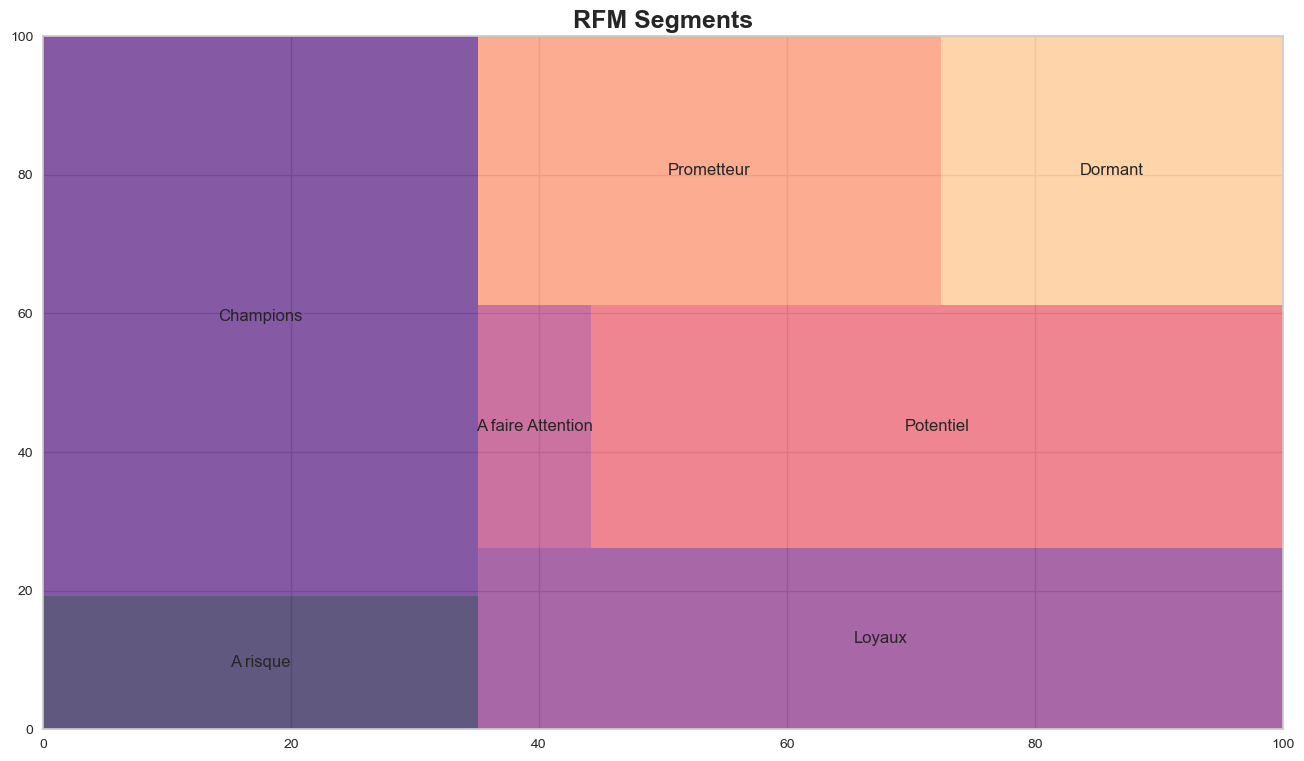

In [19]:
import squarify
#rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['A risque',
                     'Champions',
                     'Loyaux',
                     'A faire Attention',
                     'Potentiel', 
                     'Prometteur', 
                     'Dormant'], color = sns.color_palette("magma",len(rfm_level_agg)), alpha = 0.7) 
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis()
plt.show()

### Plot RFM distributions

C:\Users\kherm\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\kherm\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\kherm\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



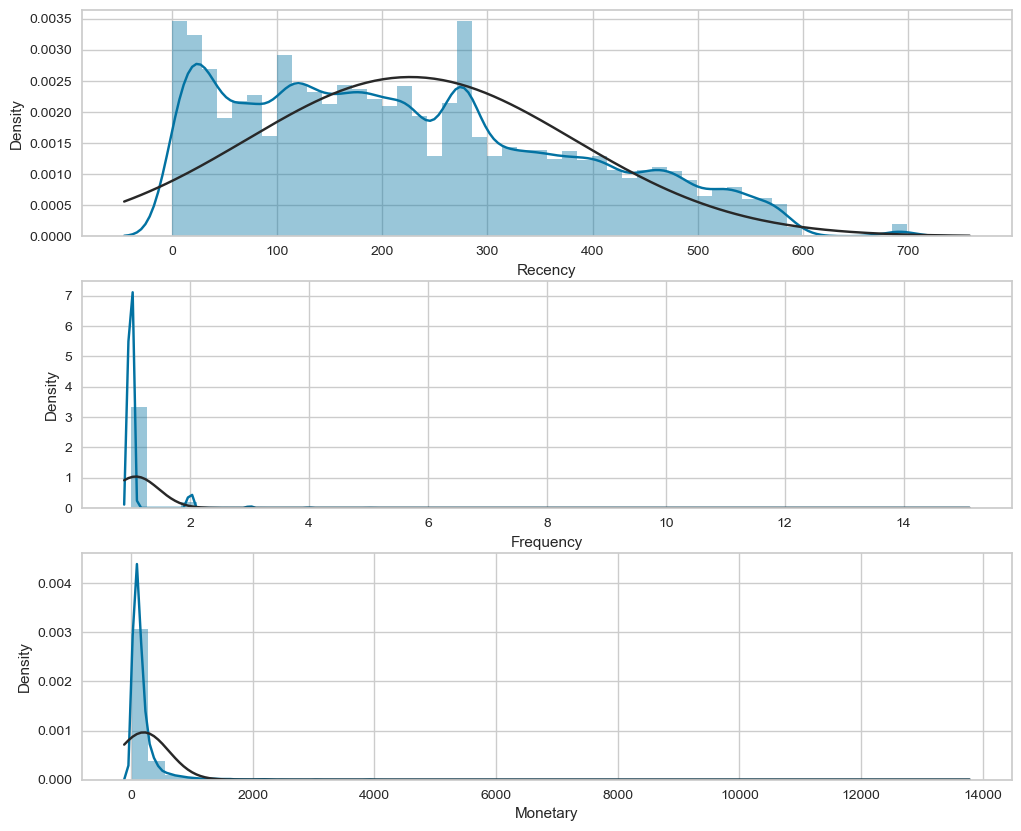

In [20]:
from scipy.stats import norm
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'],fit=norm)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'],fit=norm)
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'],fit=norm)
# Show the plot
plt.show()

In [21]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_1=rfm[['Recency',"Frequency","Monetary"]].copy()
rfm_log_1 = rfm_1.copy()
rfm_log_1[["Frequency",
           "Monetary"]] = rfm_log_1[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

C:\Users\kherm\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\kherm\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\kherm\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



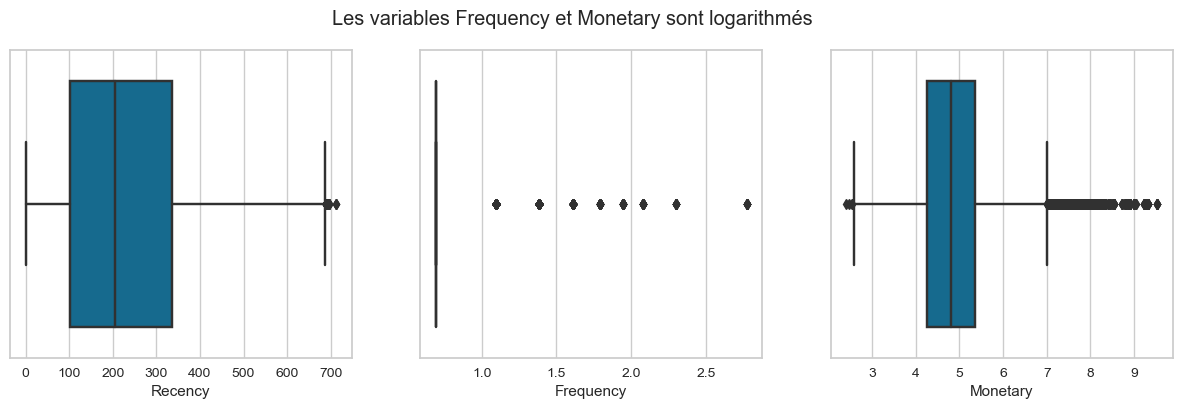

In [22]:
fig = plt.figure(1, figsize=(15, 4))

plt.suptitle("Les variables Frequency et Monetary sont logarithmés")

# Boxplot de la variable Recency
plt.subplot(131)
sns.boxplot(rfm_log_1["Recency"])

# Boxplot de la variable Frequency
plt.subplot(132)
sns.boxplot(rfm_log_1["Frequency"])

# Boxplot de la variable Monetary
plt.subplot(133)
sns.boxplot(rfm_log_1["Monetary"])
plt.show()

## Calcul du RFM Score
La méthode  consiste à quantiliser chaque segment RFM de manière à obtenir un score entre 1 et 5 pour chaque variable R, F et M.

En fonction de chaque score obtenu, le client sera attribué dans une catégorie.

In [23]:
def r_score(x, quintiles):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculate_quantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribut un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[['Recency',
                     'Frequency',
                     'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

    rfm['R'] = rfm['Recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
    rfm['M'] = rfm['Monetary'].apply(lambda x:
                                     fm_score(x, quintiles, 'Monetary'))
    return rfm

In [24]:
# Calcul des quantiles
rfm_table_1 = calculate_quantile(rfm_1)

#### Calcul des segments et des scores
Chaque client est caractérisé en fonction de la note pour chaque variable R, F M qui le caractérise

9 segments sont définis :

- Champions : achats récents, achète souvent et dépense beaucoup
- Loyal Customers : achètent régulièrement, sensibles aux promotions
- Potential Loyalist : nouveaux clients avec fréquence d'achat moyenne
- Recent Customers : achats récents, mais peu fréquents
- Promising : nouveaux acheteurs, mais peu dépensiers
- Need Attention : dépenses moyennes, moyennement fréquemment, achat moyennement récent
- About to Sleep : client qui tendent à disparaitre
- Can't Lose Them : achètaient régulièrement, besoin de les faire revenir
- At Risk : dépensaient beaucoup, achetaient souvent mais il y a lomgtemps
- Lost : peu dépensiers, peu fréquements, a acheté il y a un moment
- Others : pas catégorisable


In [25]:
# Etiquette des catégories pour la méthodologie 1
categories_1 = ["Champions",
                "Loyal Customers",
                "Potential Loyalist",
                "Recent Customers",
                "Promising",
                "Need Attention",
                "About to Sleep",
                "Can't Lose Them",
                "At Risk",
                "Lost",
                "Others"]

In [26]:
def calculate_segments(rfm):
    """
    Retourne le segment associé au client en fonction de son score pour les
    variables R, F et M

    Paramètres:
    rfm(pd.DataFrame): doit contenir les colonnes R, F et M

    Return:
    str: Nom du segment
    """

    if 4 <= rfm["R"] <= 5 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Champions"

    elif 3 <= rfm["R"] <= 5 and 3 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["R"] <= 5 and 1 <= rfm["F"] <= 3 and 1 <= rfm["M"] <= 3:
        return "Potential Loyalist"

    elif rfm["R"] >= 4 and rfm["F"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["R"] <= 4 and rfm["F"] <= 1 and rfm["M"] <= 1:
        return "Promising"

    elif 2 <= rfm["R"] <= 3 and 2 <= rfm["F"] <= 3 and 2 <= rfm["M"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["R"] <= 3 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "About to Sleep"

    elif rfm["R"] <= 1 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Can't Lose Them"

    elif rfm["R"] <= 2 and 2 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "At Risk"

    elif rfm["R"] <= 2 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "Lost"

    else:
        return "Others"

In [27]:
# RFM Score
rfm_table_1["RFM Score"] = rfm_table_1.apply(calculate_segments, axis=1)

In [28]:
# Affiche les 5 premières lignes
rfm_table_1.head()

Recency  Frequency  Monetary  R  F  M        RFM Score
96744      0.0          2   1225.05  5  5  5        Champions
19931      0.0          2    103.36  5  5  3  Loyal Customers
28152      0.0          2    772.38  5  5  5        Champions
28153      0.0          2    772.38  5  5  5        Champions
28154      0.0          2    772.38  5  5  5        Champions

#### Résumé des résultats de la segmentation

In [29]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']
# Regroupement des données
qtd_preco = rfm_table_1.groupby(['RFM Score'])
# Aggrégation des données par différentes fonctions
summary_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)
# Affichage de la table de résumé
summary_table

Recency                                                \
                     count    min        mean  median    max         std   
RFM Score                                                                  
About to Sleep        9063  259.0  306.973629  300.00  373.0   33.937244   
At Risk                 42  261.0  278.761905  276.25  304.5   14.128866   
Champions             3015    0.0   39.595834   24.50  161.0   43.090056   
Lost                  9477  374.0  466.901446  460.00  695.0   64.597786   
Loyal Customers       3561    0.0   58.320124   31.00  257.5   66.096598   
Others               37083    0.0  334.615475  318.00  713.0  123.795518   
Potential Loyalist   36821    0.0  128.342603  130.00  258.0   73.027686   
Recent Customers     15678    0.0   84.621316   85.00  162.0   46.400359   

                   Frequency                                    Monetary  \
                       count min      mean median max       std    count   
RFM Score                                                                  
About to Sleep          9063   1  1.000000    1.0   1  0.000000     9063   
At Risk                   42   2  2.000000    2.0   2  0.000000       42   
Champions               3015   2  2.238143    2.0   7  0.665037     3015   
Lost                    9477   1  1.000000    1.0   1  0.000000     9477   
Loyal Customers         3561   2  2.212581    2.0   9  0.754030     3561   
Others                 37083   1  1.036594    1.0  15  0.346624    37083   
Potential Loyalist     36821   1  1.000000    1.0   1  0.000000    36821   
Recent Customers       15678   1  1.000000    1.0   1  0.000000    15678   

                                                                       
                       min        mean   median       max         std  
RFM Score                                                              
About to Sleep       10.07   61.015554   61.880     97.98   20.357592  
At Risk              72.23  150.221667  106.530    307.36   84.734648  
Champions           148.22  389.347887  236.780   3785.82  466.003443  
Lost                 12.28   60.086609   60.460     97.98   20.590128  
Loyal Customers      61.06  107.806186  100.030    691.30   50.054295  
Others               15.62  329.500182  196.990  13664.08  569.702289  
Potential Loyalist   10.89   80.266519   76.390    148.15   34.771306  
Recent Customers    148.16  396.755359  242.785  10055.22  543.780804

#### Radar Chart des différentes catégories

In [30]:
# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette("husl", len(categories_1))
colors_1 = {label: color for label, color in zip(categories_1,
                                                 palette_1.as_hex())}

In [31]:
rfm_table_1

Recency  Frequency  Monetary  R  F  M        RFM Score
96744      0.0          2   1225.05  5  5  5        Champions
19931      0.0          2    103.36  5  5  3  Loyal Customers
28152      0.0          2    772.38  5  5  5        Champions
28153      0.0          2    772.38  5  5  5        Champions
28154      0.0          2    772.38  5  5  5        Champions
...        ...        ...       ... .. .. ..              ...
51774    695.0          1    154.57  1  1  4           Others
60622    695.0          1     40.95  1  1  1             Lost
58708    713.0          1    143.46  1  1  3           Others
58707    713.0          1    143.46  1  1  3           Others
58709    713.0          1    143.46  1  1  3           Others

[114740 rows x 7 columns]

In [32]:
rfm_table_2=rfm_table_1.drop(columns=["R", "F", "M"])

In [33]:
 # Aggrégation par moyenne des valeurs par segment
df_plot = rfm_table_2.groupby(['RFM Score']).agg("mean")
df_plot

Recency  Frequency    Monetary
RFM Score                                            
About to Sleep      306.973629   1.000000   61.015554
At Risk             278.761905   2.000000  150.221667
Champions            39.595834   2.238143  389.347887
Lost                466.901446   1.000000   60.086609
Loyal Customers      58.320124   2.212581  107.806186
Others              334.615475   1.036594  329.500182
Potential Loyalist  128.342603   1.000000   80.266519
Recent Customers     84.621316   1.000000  396.755359

In [34]:
# Transformation MinMax -> [0, 1]
df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
                           columns=list(df_plot.columns),
                           index=df_plot.index)
df_plot_std

Recency  Frequency  Monetary
RFM Score                                        
About to Sleep      0.625730   0.000000  0.002759
At Risk             0.559707   0.807661  0.267726
Champions           0.000000   1.000000  0.977998
Lost                1.000000   0.000000  0.000000
Loyal Customers     0.043819   0.979355  0.141740
Others              0.690418   0.029555  0.800233
Potential Loyalist  0.207689   0.000000  0.059940
Recent Customers    0.105371   0.000000  1.000000

In [35]:
# Noms des variables
categories = list(df_plot.columns)
# Nombre de variables
N =len(list(df_plot.columns)) #Attention changement

In [36]:
pi=np.pi
# Quel sera l'angle de chaque axe ?
# On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N+1)]
angles

[0.0, 2.0943951023931953, 4.1887902047863905, 6.283185307179586]

In [37]:
rfm_table_2['RFM Score'].unique()

array(['Champions', 'Loyal Customers', 'Others', 'Potential Loyalist',
       'Recent Customers', 'About to Sleep', 'At Risk', 'Lost'],
      dtype=object)

In [38]:
list(df_plot_std.loc['Champions'].values)

[0.0, 0.9999999999999999, 0.9779977444860565]

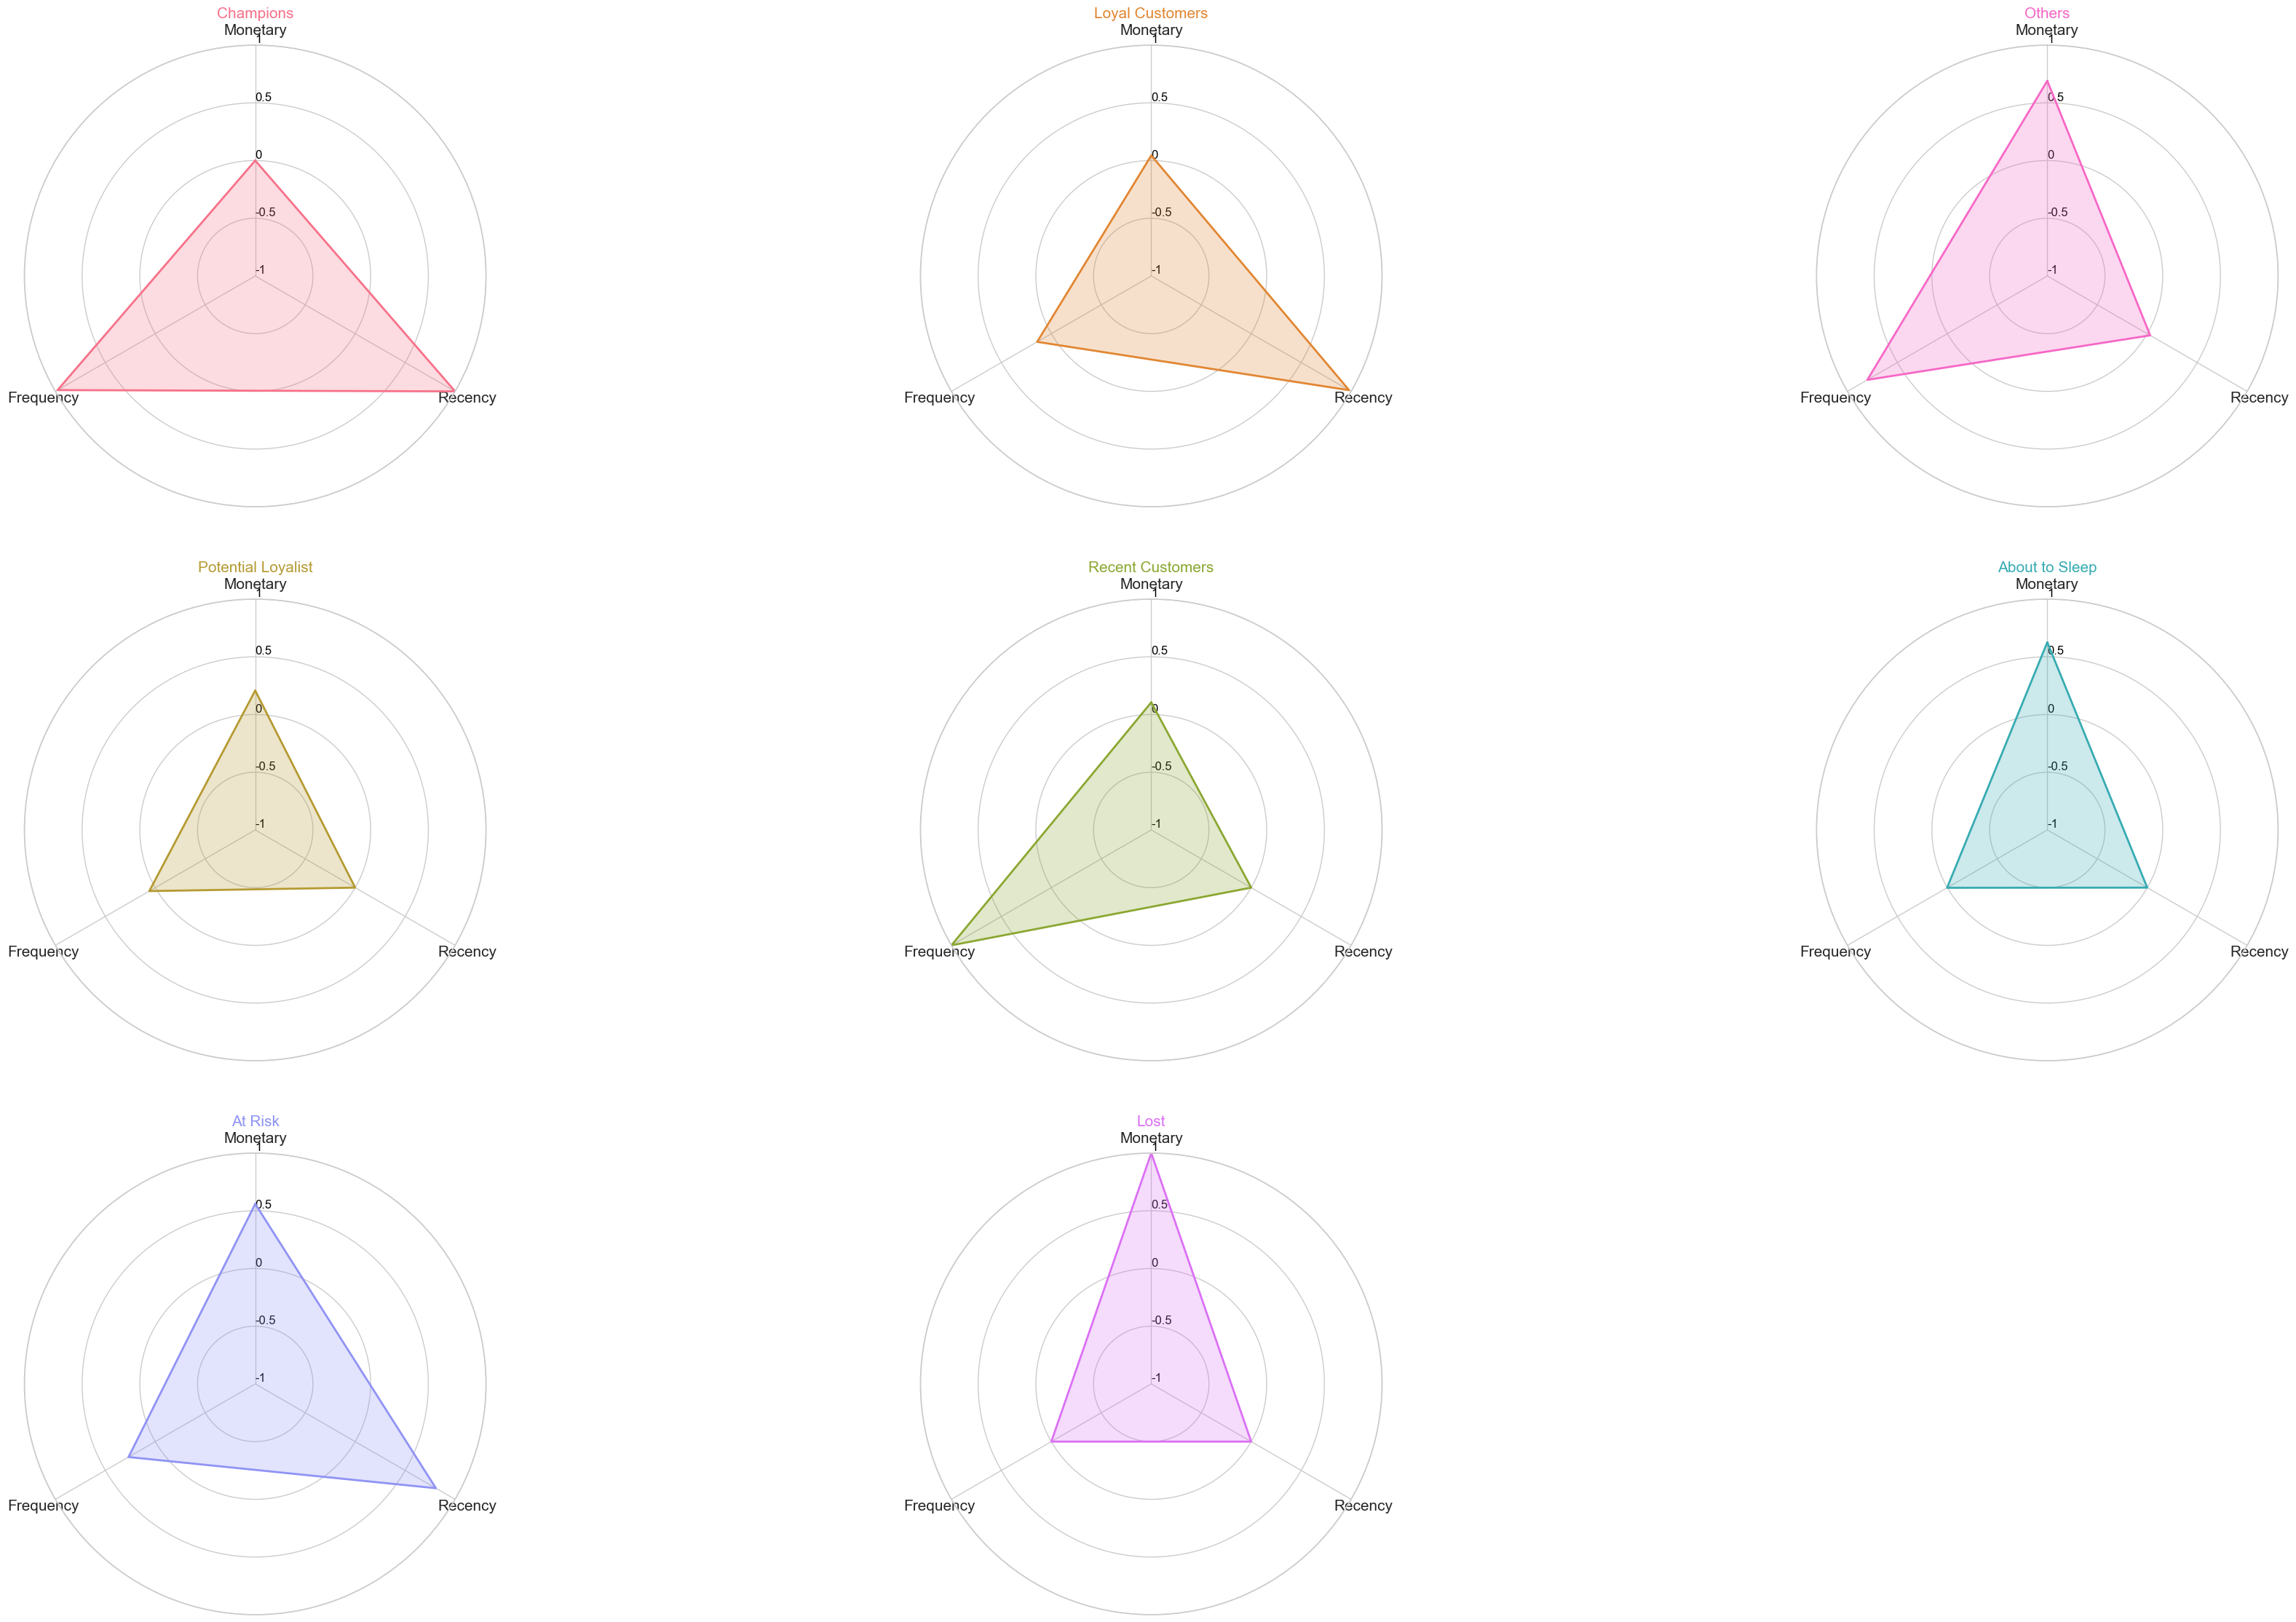

In [39]:
fig = plt.figure(1, figsize=(45, 28))

 # Trace un radar chart pour chaque segment
for i, segment in enumerate(rfm_table_2['RFM Score'].unique()):
        sub_plot=[3, 3]

        ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar=True)

        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
         # Quel sera l'angle de chaque axe ?
        # On divise un tour complet par le nombre de variables
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        

        # Draw one axe per variable + add labels labels yet
        plt.yticks(color="grey", size=2)
        values = list(df_plot_std.loc[segment].values)
        values += values[:1]
        ax.plot(angles, values, colors_1[segment],
                'o-', linewidth=2, linestyle='solid')
        ax.fill(angles, values, colors_1[segment], alpha=0.25)
        ax.set_xticks(angles[1:])
        ax.set_xticklabels(categories, size=15)
        plt.yticks([-1, -0.5, 0, 0.5, 1],
                   ["-1", "-0.5", "0", "0.5", "1"],
                   color="black",
                   size=12)
        ax.set_title(segment, size=15, color=colors_1[segment])
        ax.grid(True)
        plt.ylim(-1, 1)

plt.show()

In [40]:
values

[0.9999999999999999, 0.0, 0.0, 0.9999999999999999]

In [41]:
pi=np.pi
def radar_plot(rfm_table,
               label_score,
               colors,
               sub_plot=[3, 3],
               figsize=(36, 18)):

    """
    Pour chaque cluster/segments, trace un radar chart représentant
    la moyenne des individus pour les variables Recency, Monetary
    et Frequency, ainsi que le nombre d'individus dans le cluster/segment
    en question.
    rfmTable(pd.DataFrame): Table de résultats, doit contenir
    les 3 variables Recency, Frequency et Monetary
    ainsi que la colonne avec les segments de chaque individu
    label_score: nom de la segmentation
    colors(list): code couleur
    """

    # Aggrégation par moyenne des valeurs par segment
    df_plot = rfm_table.groupby([label_score]).agg("mean")

    # Transformation MinMax -> [0, 1]
    df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
                           columns=list(df_plot.columns),
                           index=df_plot.index)

    # Noms des variables
    categories = list(df_plot.columns)
    # Nombre de variables
    N = len(list(df_plot.columns))

    fig = plt.figure(1, figsize=figsize)

    # Trace un radar chart pour chaque segment
    for i, segment in enumerate(rfm_table[label_score].unique()):

        ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar=True)

        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
           # Quel sera l'angle de chaque axe ?
           # On divise un tour complet par le nombre de variables
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]


        # Draw one axe per variable + add labels labels yet
        plt.yticks(color="grey", size=2)
        values = list(df_plot_std.loc[segment].values)
        values += values[:1]
        ax.plot(angles, values, colors[segment],
                'o-', linewidth=2, linestyle='solid')
        ax.fill(angles, values, colors[segment], alpha=0.25)
        ax.set_xticks(angles[1:])
        ax.set_xticklabels(categories, size=15)
        plt.yticks([-1, -0.5, 0, 0.5, 1],
                   ["-1", "-0.5", "0", "0.5", "1"],
                   color="black",
                   size=12)
        ax.set_title(segment, size=15, color=colors[segment])
        ax.grid(True)
        plt.ylim(-1, 1)

    plt.show()

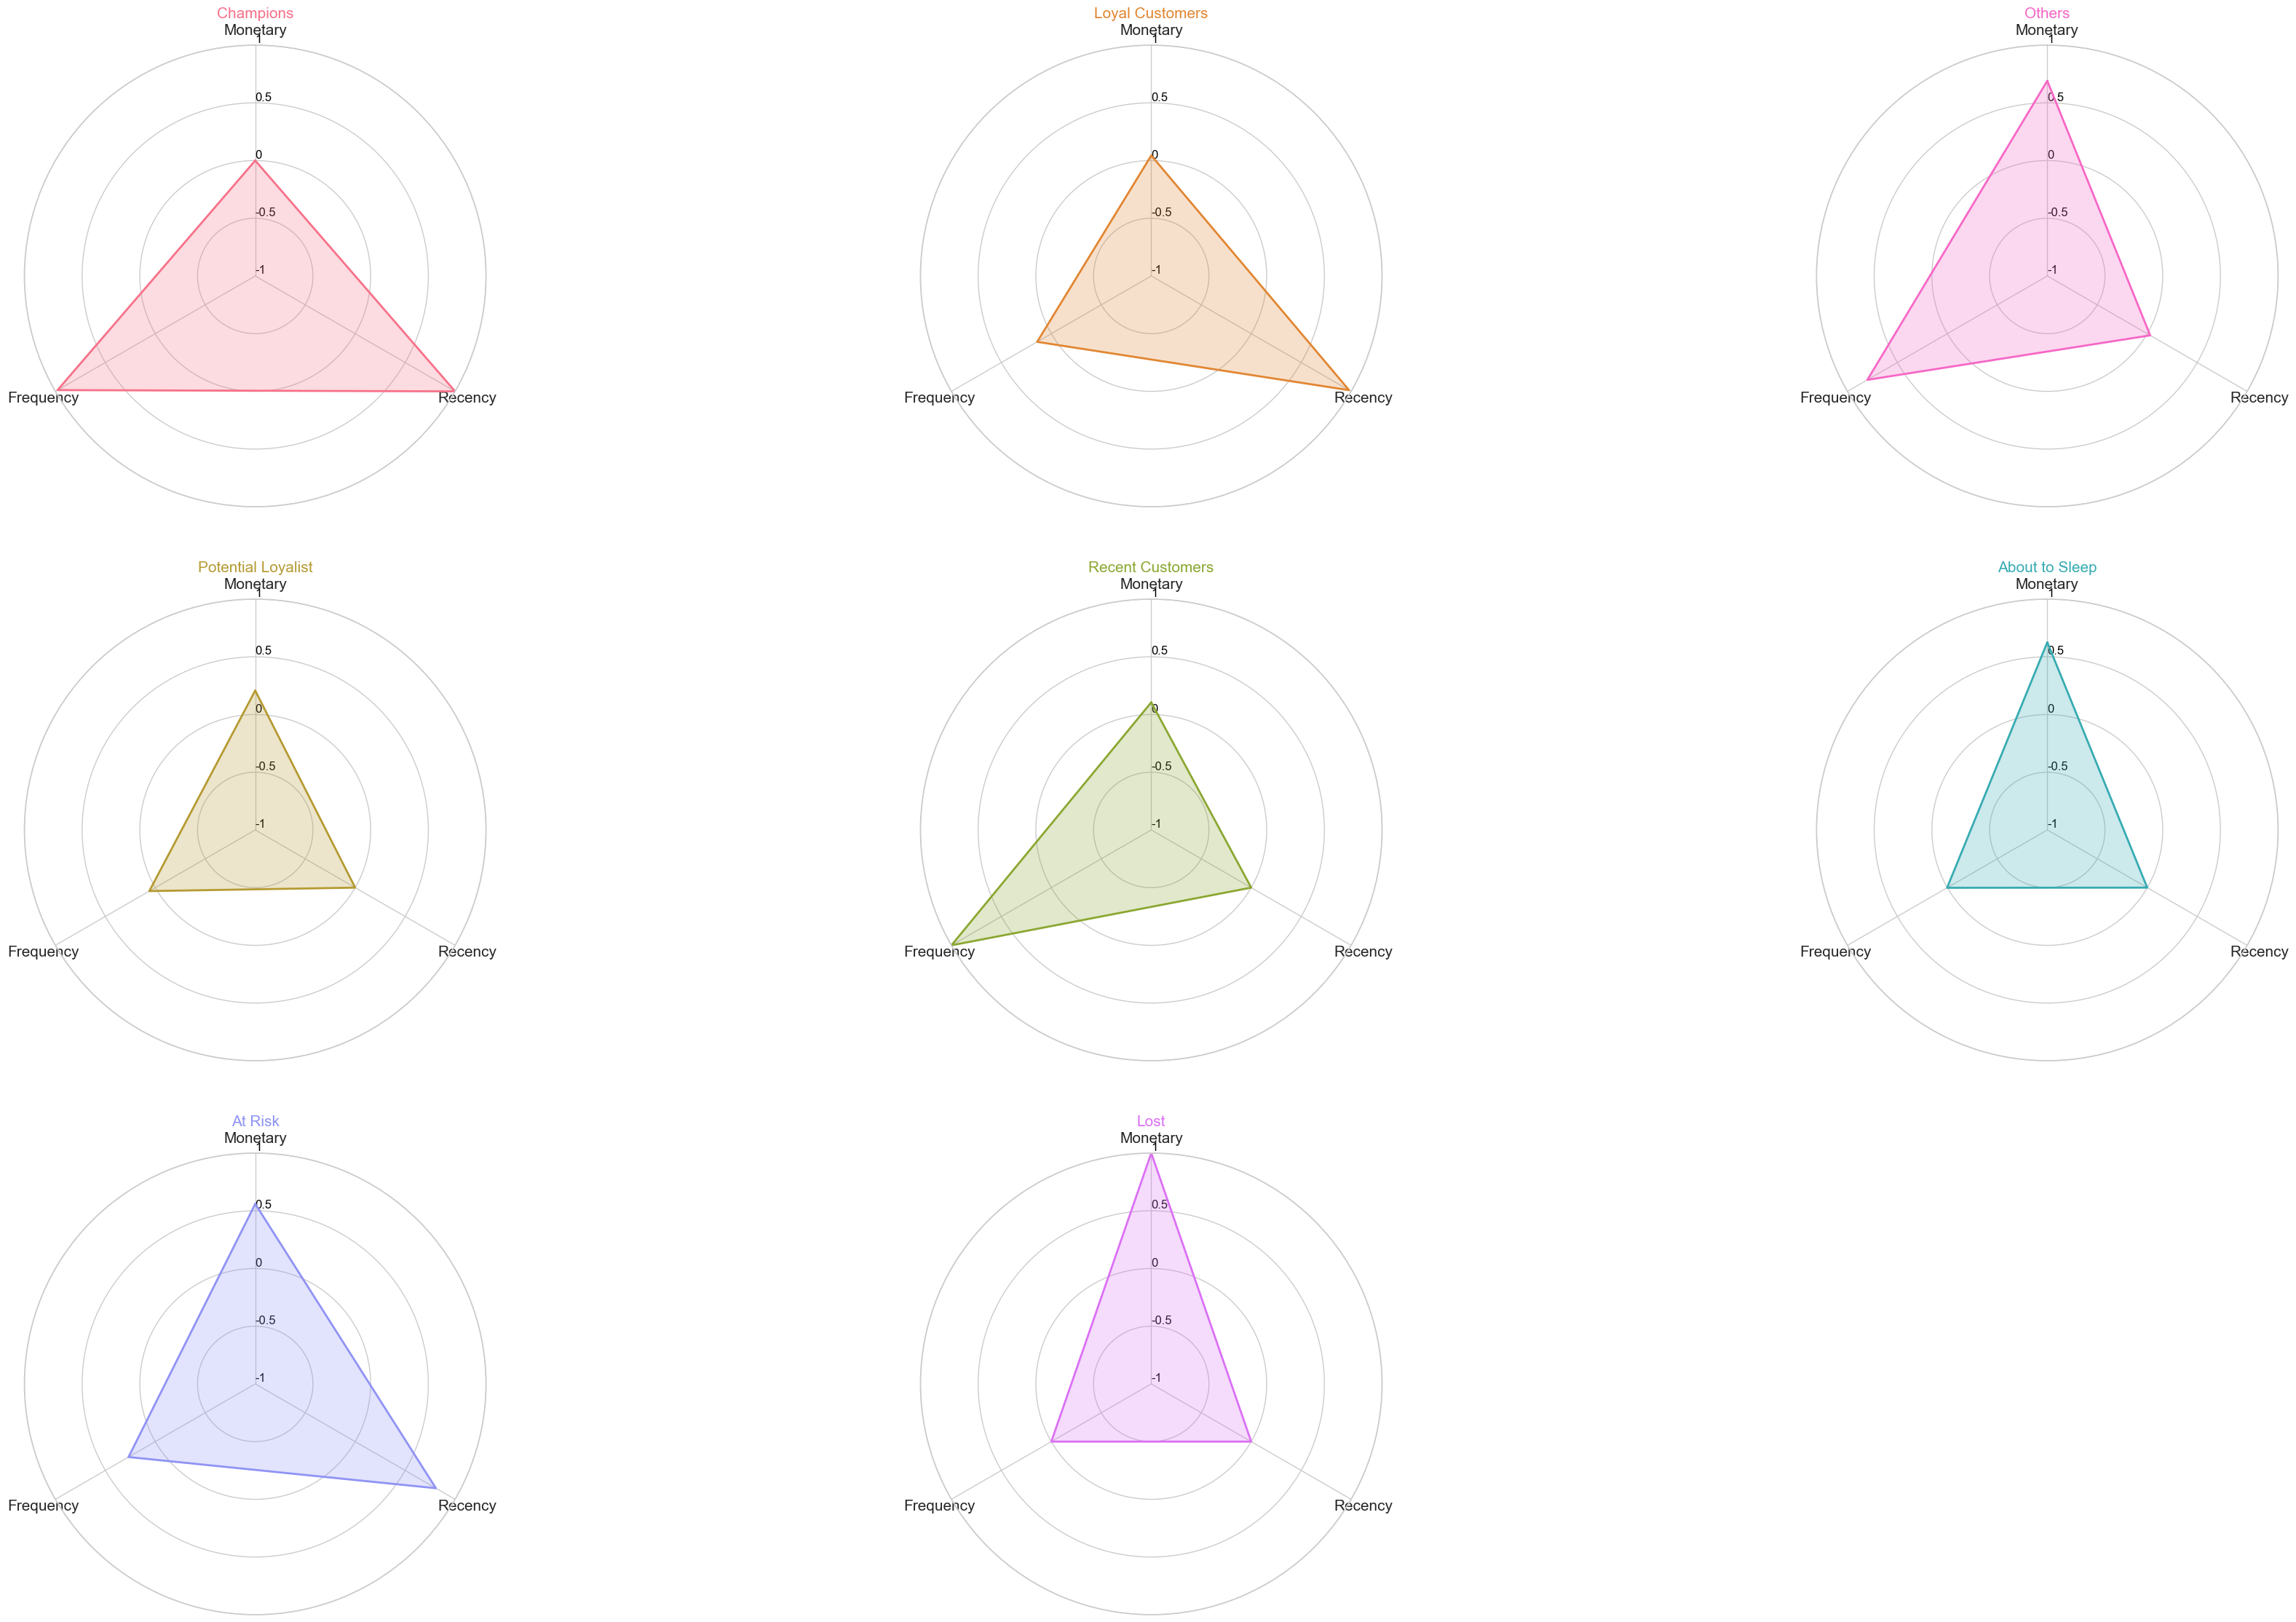

In [42]:
# Radar plot pour la segmentation
radar_plot(rfm_table_2,
           'RFM Score',
           colors_1,
           sub_plot=[3, 3],
           figsize=(45, 28))

# Clustering avec l'algorithme du K-Means
## Explication de l'algorithme
C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes *(ou clusters).

L’algorithme K-means identifie un certain nombre de centroïdes dans un ensemble de données, un centroïde étant la moyenne arithmétique de tous les points de données appartenant à un cluster particulier.

Après avoir initialisé des centroïdes en prenant des données au hasard dans le jeu de données, K-means alterne plusieurs fois ces deux étapes pour optimiser les centroïdes et leurs groupes.
L’algorithme converge après un certain nombre d'itérations et trouve un découpage stable du jeu de données. Cependant, le nombre de Clusters est à définir par l'utilisateur.

## Méthode du coude
KElbowVisualizer de Yellowbrick implémente la méthode du «coude» pour sélectionner le nombre optimal de clusters en ajustant le modèle K-Means avec une plage de valeurs pour K. Si le graphique en courbes ressemble à un bras, alors le «coude» (le point d'inflexion sur la courbe) est une bonne indication du nombre de K optimal. Cette méthode s’appuie sur la notion d’inertie. On définit cette dernière comme ceci : la somme des distances euclidiennes entre chaque point et son centroïde associé.

## Silhoutte Score
Une approche plus précise mais qui requiert plus de temps de calcul est le coefficient de silhouette. Il mesure la similitude d’un point de données à l’intérieur d’un groupe par rapport à d’autres groupes.

Ce coefficient peut varier entre -1 et +1. Un coefficient proche de +1 signifie que l’observation est située bien à l’intérieur de son propre cluster, tandis qu’un coefficient proche de 0 signifie qu’elle se situe près d’une frontière ; enfin, un coefficient proche de -1 signifie que l’observation est associée au mauvais cluster.

## Variables RFM avec Kmeans

### Normalisation

In [61]:
clustering_fm = rfm[['Recency',"Frequency","Monetary"]].copy()
clustering_fm[["Frequency",
           "Monetary"]] = clustering_fm[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))
X=clustering_fm.copy()
numerical_features = list(clustering_fm.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['Recency', 'Frequency', 'Monetary']

In [62]:


#Normalisation
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

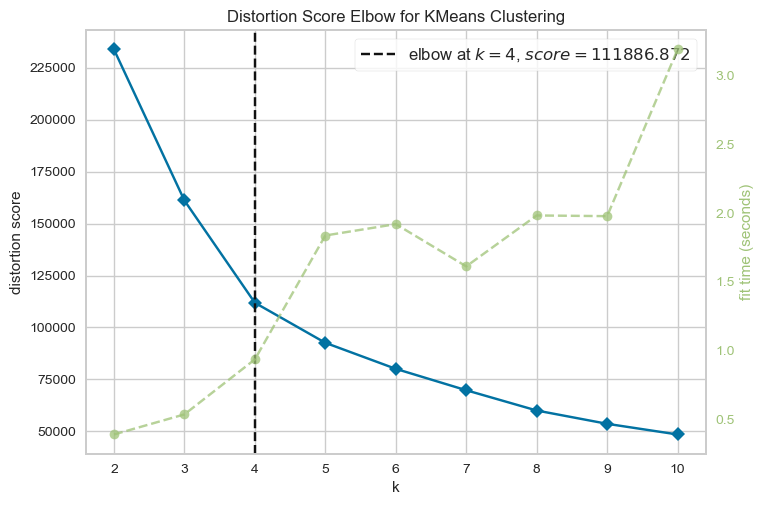

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Le nombre de clusters optimal est 4.

### Coefficient de silhoutte

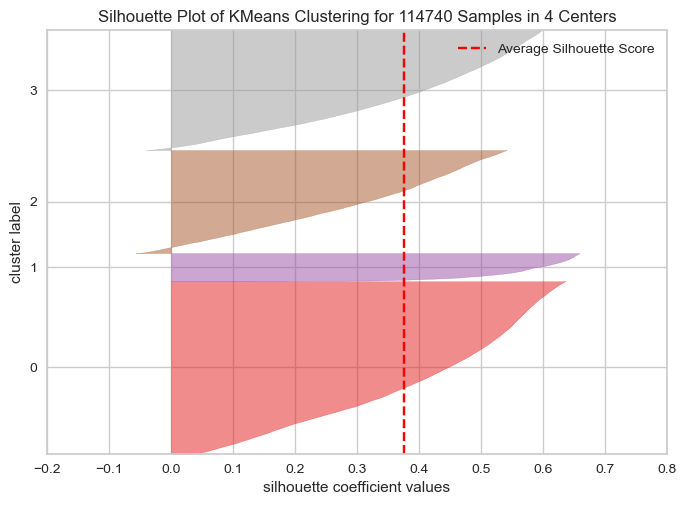

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 114740 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [64]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])


silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score calculé est raisonnable. 

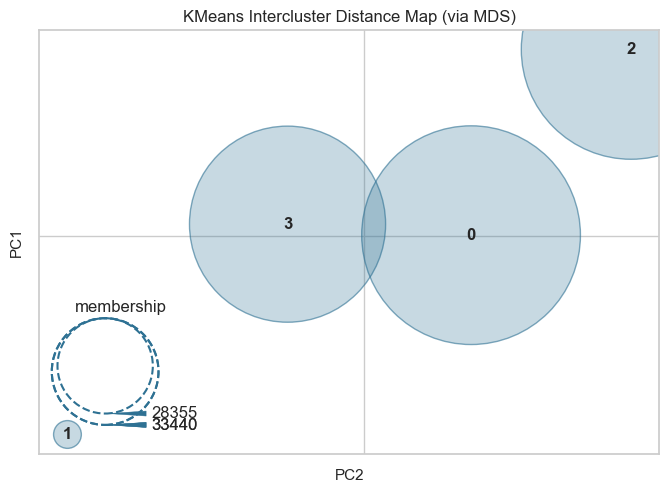

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [65]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Les clusters  sont distincts.

## Préparation du radar plot unifié 

In [66]:
##### KMeans Pipeline with best K
kmeans_model = Pipeline([
                         ("kmeans", KMeans(K))])

In [67]:
clustering_fm

Recency  Frequency  Monetary
96744      0.0   1.098612  7.111553
19931      0.0   1.098612  4.647846
28152      0.0   1.098612  6.650771
28153      0.0   1.098612  6.650771
28154      0.0   1.098612  6.650771
...        ...        ...       ...
51774    695.0   0.693147  5.047096
60622    695.0   0.693147  3.736478
58708    713.0   0.693147  4.973003
58707    713.0   0.693147  4.973003
58709    713.0   0.693147  4.973003

[114740 rows x 3 columns]

In [68]:
X=clustering_fm.copy()
numerical_features = list(clustering_fm.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['Recency', 'Frequency', 'Monetary']

In [69]:
#Normalisation
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

In [70]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
kmeans_model.fit(X_scaled)
X_scaled["kmeans_label"] = kmeans_model.named_steps['kmeans'].labels_
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

Recency  Frequency  Monetary
kmeans_label                               
0             1.238461  -0.249203 -0.236527
1            -1.130060   3.498309  0.084130
2            -0.197641  -0.249203  1.182070
3            -0.556229  -0.249203 -0.583659

In [96]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [72]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

### Explications des clusters : 
1. Cluster 0 : R faible , M moyen et F élevée --> Clients nouveaux
2. Cluster 1 : R et M élevé mais F faible --> clients qui tendent à disparaître à risque.
3. Cluster 2 : F élevé et M moyen mais R faible --> Clients potentiels
4. Cluster 3 : R et M moyens et F faible --> Clients à activer 


### Projection des segments et Snake plot RFM

In [76]:


#fonction de modélisation et d'affichage des clusters
def clustering(X,k,n):
    '''
    X= données a l'entrée,
    k Nombre de clusters
    n= nombre de composantes PCA pour la projection
    '''
    #kMeans
    model= KMeans(n_clusters=k)
    model.fit(X)
    model_labels=model.labels_
    print('le score est',model.inertia_)

    #Apc pour une meilleure projection
    pca = PCA(n_components=n)
    pca.fit(X)
    X_trans=pca.transform(X)
    plt.scatter(X_trans[:,0], X_trans[:,1], c=model.labels_,edgecolors='face')
    plt.title('la projection des segments')
    return model.labels_

def snake_plot(df, var):

    # Melt data into long format
    df_melt = pd.melt(df.reset_index(), 
                        id_vars=['customer_unique_id', 'cluster'],
                        value_vars=var, 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='cluster')
    plt.title('Snake Plot des différents clusters', fontsize='18')
    
    return

In [74]:
#fonction qui calcule plusieurs indicateurs statistiques 
def rfm_clusters_stats(df):
    df_new = df.groupby(['cluster']).agg({'mean','median','min','max'
                                         }).round(0)
    df_new['count']=df['cluster'].value_counts()
    return df_new


#Fonction de visualisation des clusters
def visualisation_cluster(data,model_labels,var_rfm):
    #création de la colonne cluster
    data['cluster']=model_labels
    #calcul de la moyenne des feautures par cluster
    rfm_clusters_stats(data)
    #creation de la dataframe 
    data_stats=pd.DataFrame(rfm_clusters_stats(data))
    #visualisation des segments 
    plt.figure(figsize=(10, 6))
    squarify.plot(sizes=data_stats["count"], label=data_stats.index, color=["b","g","r","m","c", "y"], alpha=0.7)
    plt.suptitle("segmentation des clients", fontsize=25)
    
    # Visualisation graphique features selon les labels
    plt.figure(figsize=(15, 20))
    for col, x in zip(var_rfm,
                  range(1, len(data.columns))):
        plt.subplot(3,2,x)
        sns.boxplot(y=col, x='cluster',
        data=data, showfliers=False)
        plt.title('la repartition de la variable '+col , fontsize='18')
    plt.show()
    #snake plot 
    snake_plot(data,var_rfm)
    return data, data_stats

In [75]:
data_k = rfm[['customer_unique_id','Recency',"Frequency","Monetary"]].copy()
data_k[["Frequency",
           "Monetary"]] = data_k[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))
data_k.head()

customer_unique_id  Recency  Frequency  Monetary
96744  d77aa95864ae5b42160937615628723a      0.0   1.098612  7.111553
19931  2ca8ef8560c5cd0f9ddb65d1b1b51380      0.0   1.098612  4.647846
28152  3ec83b54e0afb70def9480cd6b9097f7      0.0   1.098612  6.650771
28153  3ec83b54e0afb70def9480cd6b9097f7      0.0   1.098612  6.650771
28154  3ec83b54e0afb70def9480cd6b9097f7      0.0   1.098612  6.650771

le score est 209316025.70853442


C:\Users\kherm\AppData\Local\Temp\ipykernel_30712\4253491600.py:3: FutureWarning:

['customer_unique_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.

C:\Users\kherm\AppData\Local\Temp\ipykernel_30712\4253491600.py:3: FutureWarning:

['customer_unique_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



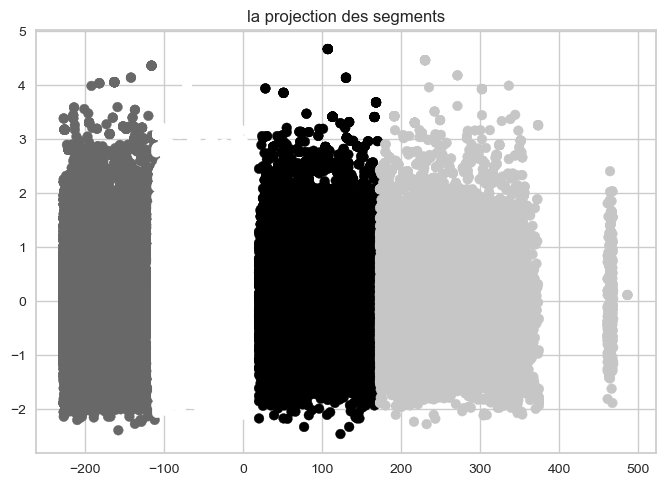

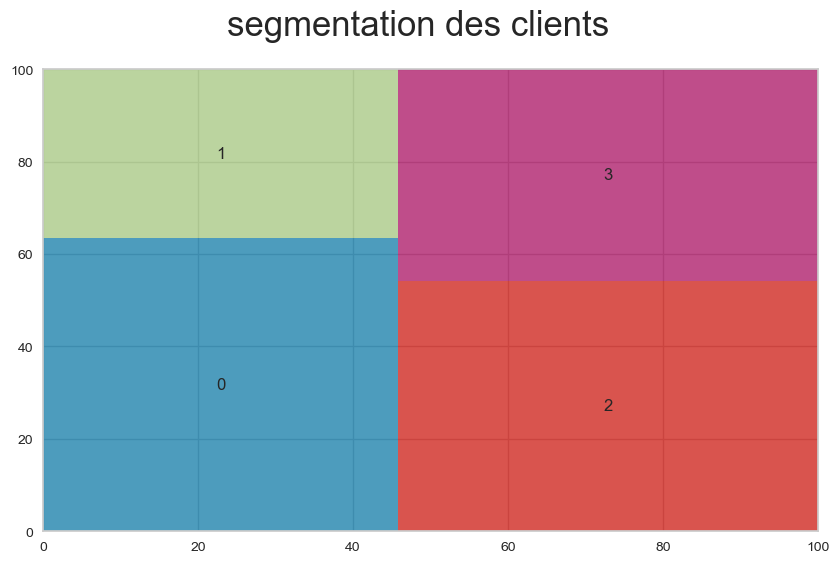

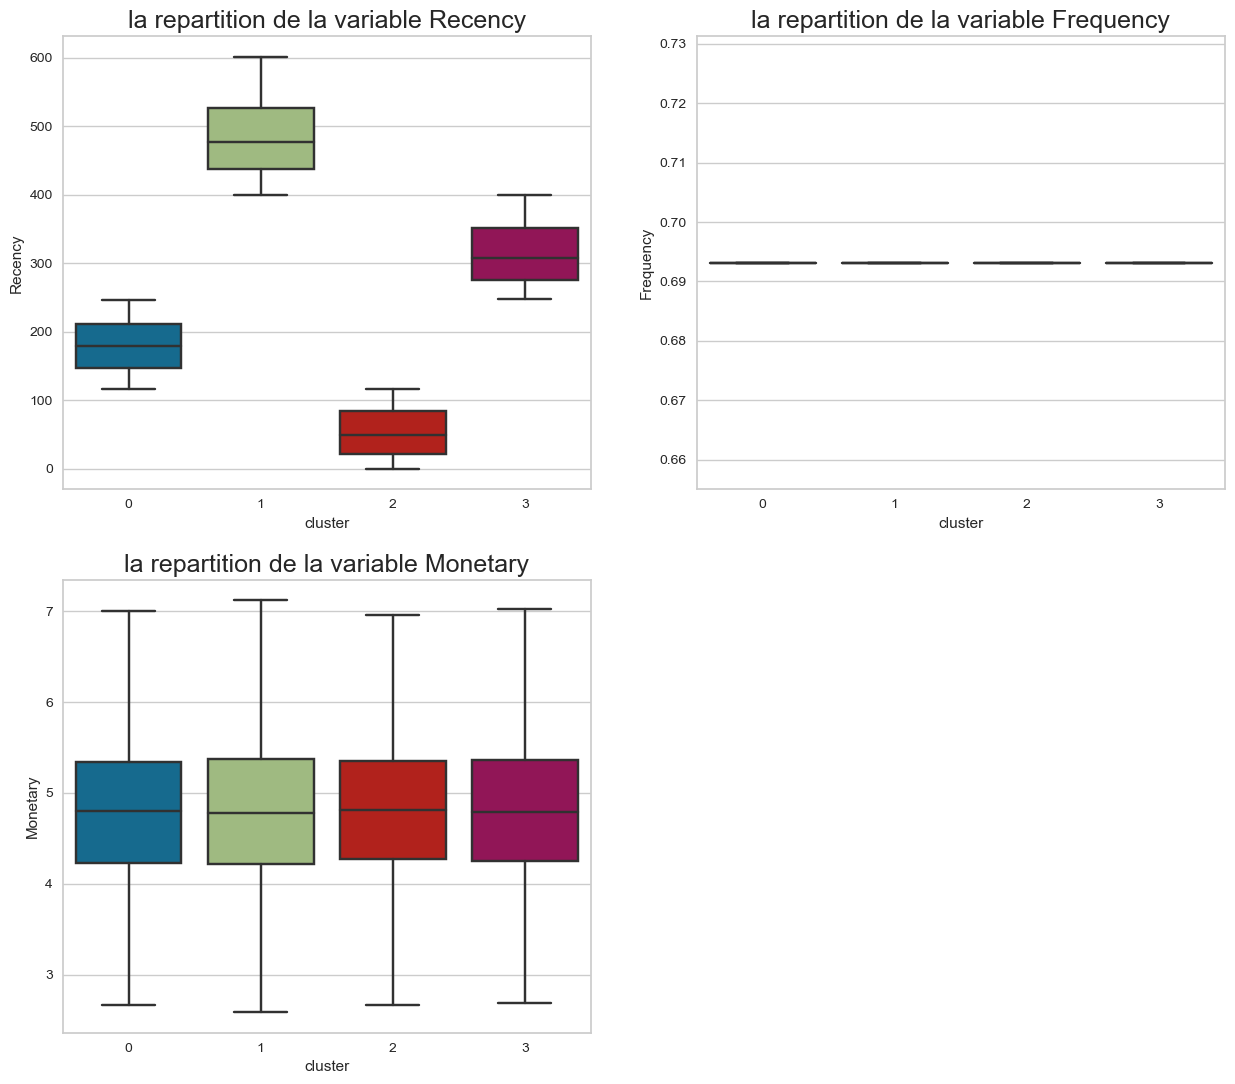

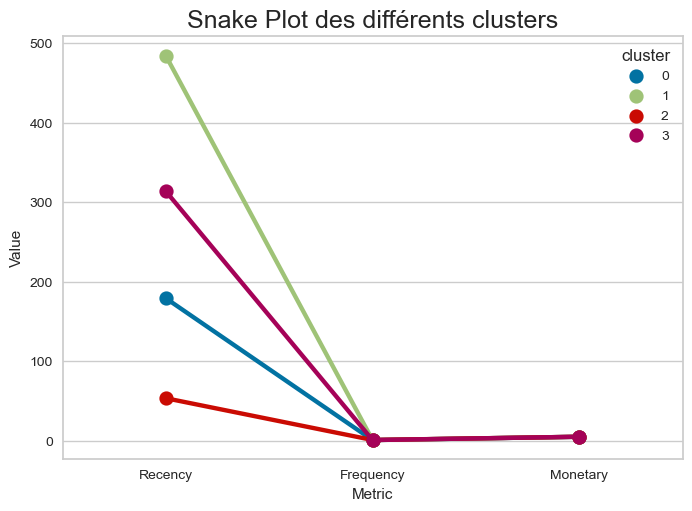

In [77]:
var_rfm=['Recency', 'Frequency', 'Monetary']

model_labels=clustering(X,4,2)

data_k,data_k_mean=visualisation_cluster(data_k,model_labels,var_rfm)

# Clustering RFM avec quelques variables 

In [85]:
data=df.copy()
data=data.rename(columns={"nb_orders": "Frequency", "mean_price_order": "Monetary","order_mean_delay":"Recency"})
new_feats=['customer_unique_id','Recency', 'Frequency', 'Monetary','mean_review_score','total_items','mean_payment_installments']
data_nf=data[new_feats]
data_nf.set_index('customer_unique_id', inplace=True)

In [80]:
def plot_hist(rfm, figsize=(20, 10)):

    plt.figure(1, figsize=figsize)

    for i, col in enumerate(rfm):
        plt.subplot(len(rfm.columns), 1, i + 1)
        plt.hist(rfm[col],
                 bins=int(1 + np.log2(len(rfm))),
                 label='skweness : ' + str(round(rfm[col].skew(), 2)),
                 density=True)
        plt.ylabel("Nombre de clients (%)")
        plt.xlabel(col)
        plt.legend()
    plt.show()

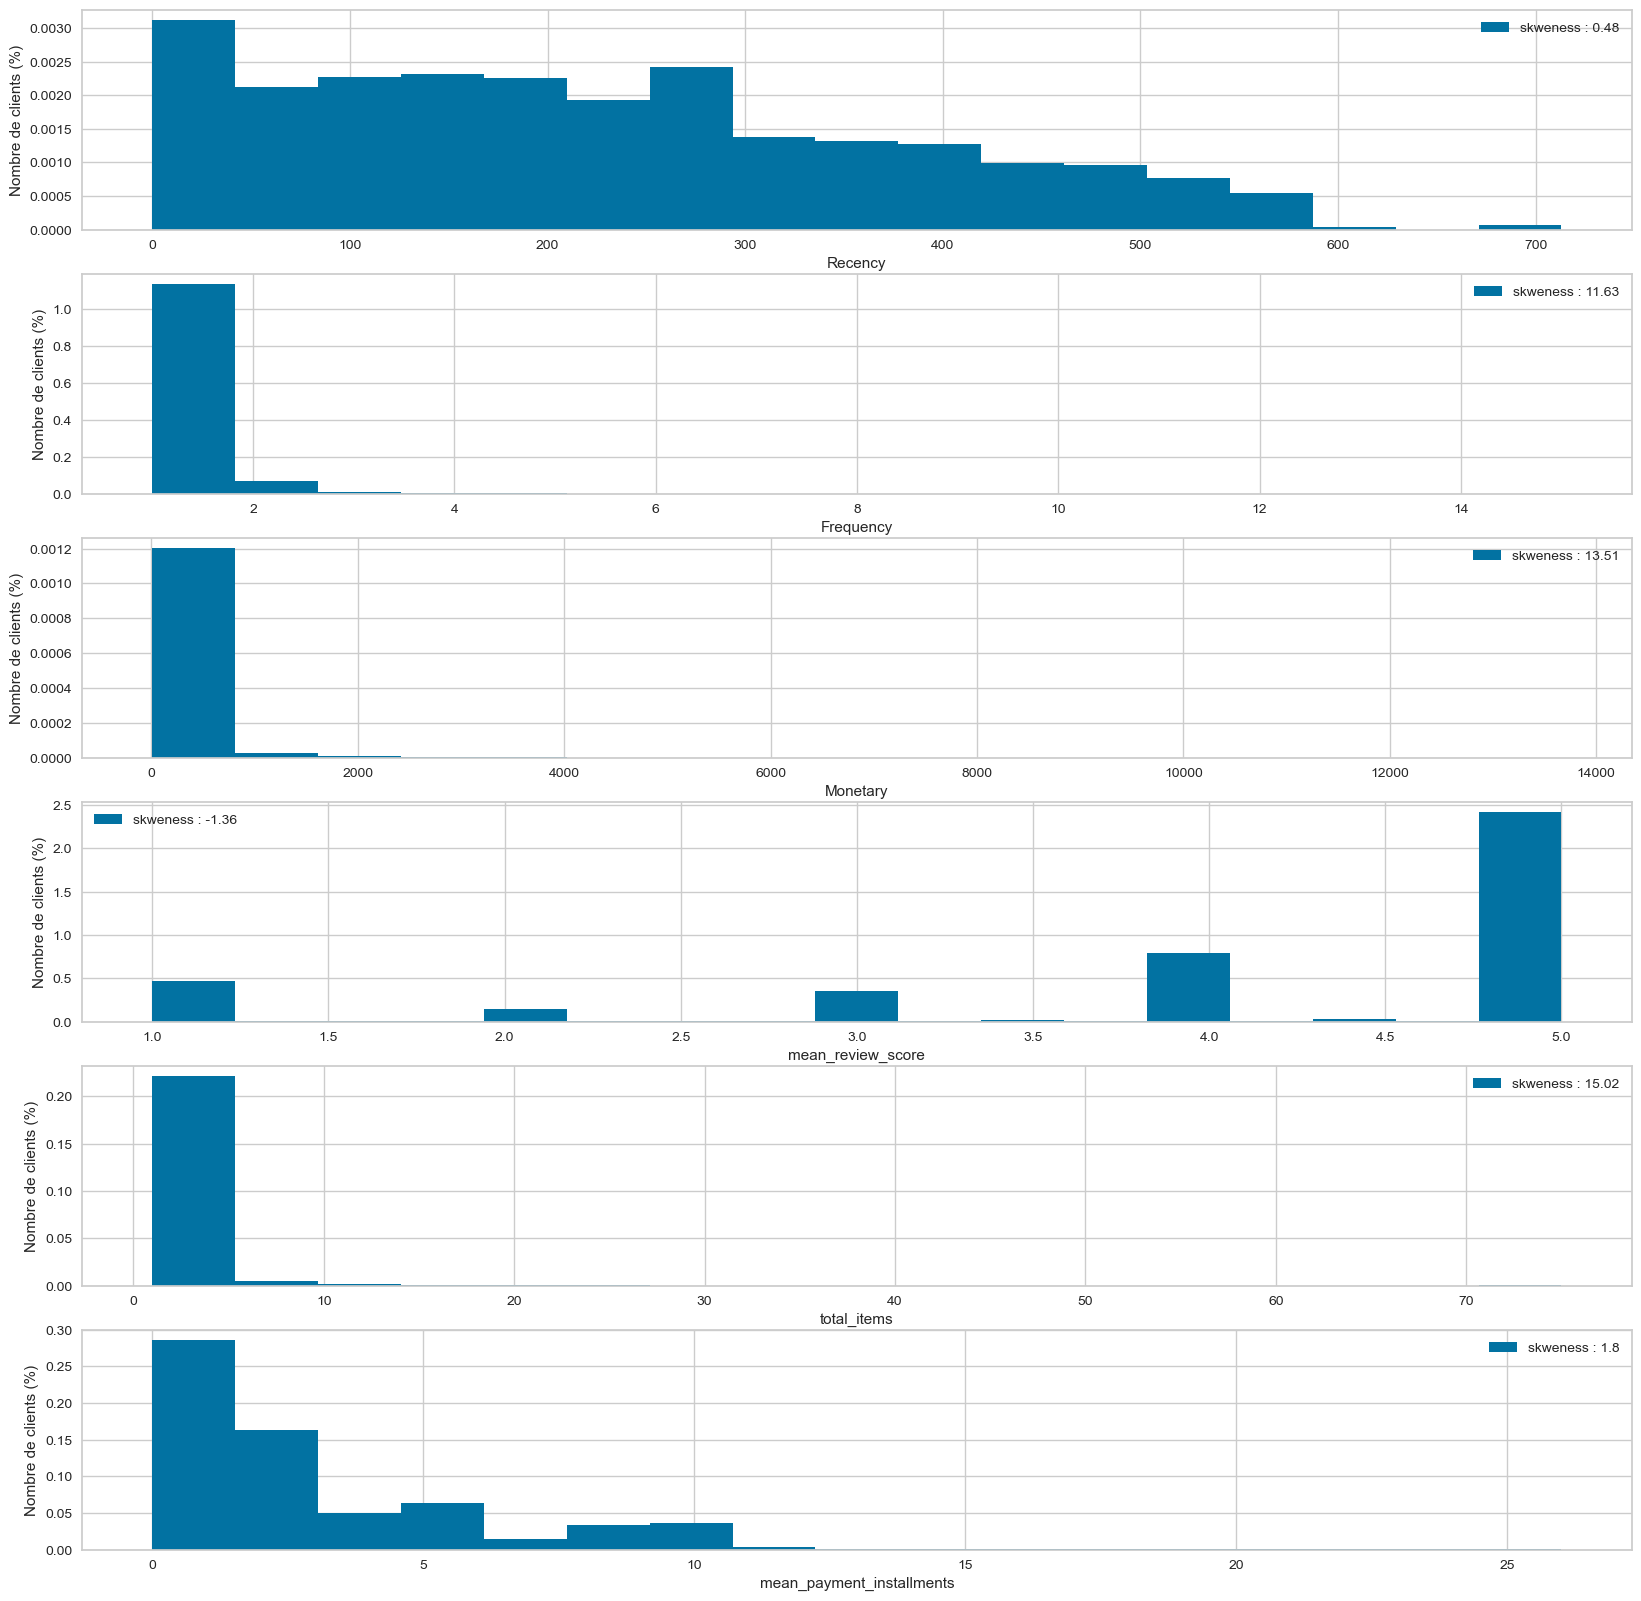

In [83]:
plot_hist(data_nf, figsize=(20, 20))

In [86]:
data_nf[["Frequency",
           "Monetary",'mean_review_score','total_items','mean_payment_installments']] = data_nf[["Frequency",
                                     "Monetary",'mean_review_score','total_items','mean_payment_installments']].apply(lambda x:
                                                        np.log(1 + x))

C:\Users\kherm\AppData\Local\Temp\ipykernel_30712\3116036255.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
numerical_features = list(data_nf.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['Recency',
 'Frequency',
 'Monetary',
 'mean_review_score',
 'total_items',
 'mean_payment_installments']

In [88]:
# Normalisation
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

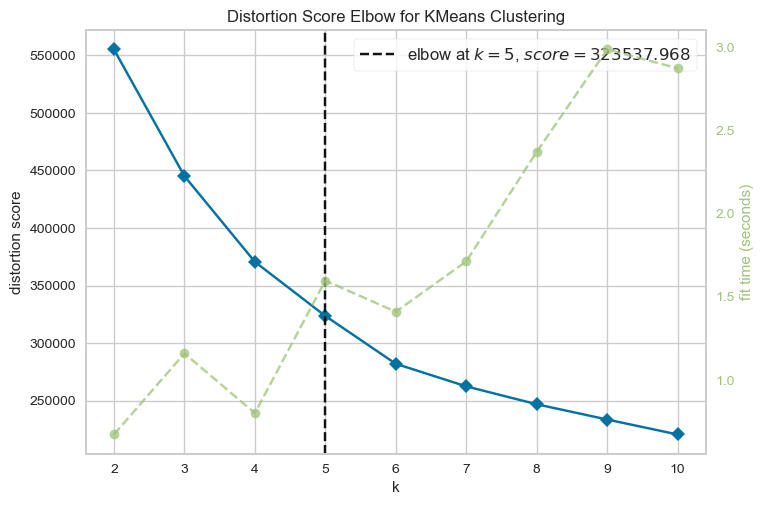

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [89]:
X = data_nf.copy()
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

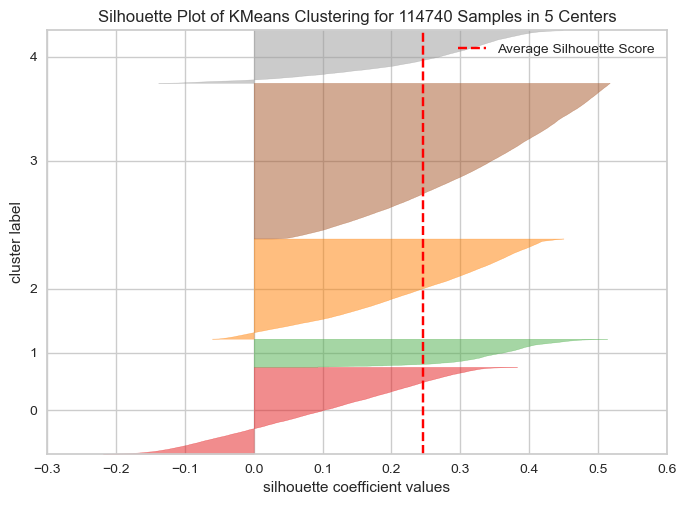

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 114740 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [90]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

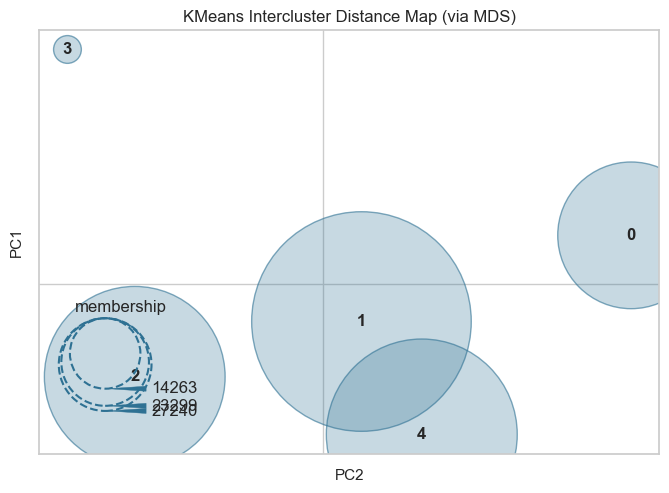

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [91]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [97]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
##### KMeans Pipeline with best K
kmeans_model = Pipeline([
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X_scaled)
X_scaled["kmeans_label"] = kmeans_model.named_steps['kmeans'].labels_
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

Recency  Frequency  Monetary  mean_review_score  total_items  \
kmeans_label                                                                  
0            -0.583822  -0.249203 -0.442638           0.373137    -0.376172   
1             0.026805  -0.249203  0.227035          -2.340198     0.213423   
2             1.192702  -0.249203 -0.348203           0.352344    -0.317556   
3             0.015277  -0.249203  1.022462           0.315690     0.452675   
4            -1.130060   3.498309  0.084130           0.082280     1.400873   

              mean_payment_installments  
kmeans_label                             
0                             -0.533148  
1                              0.071047  
2                             -0.279829  
3                              1.158671  
4                              0.208174

In [98]:

plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

- Cluster 0 : Clients à risque - achètent peu, notent bien les produits. 
- Cluster 1 : Clients à activer - achats récents, profitent du paiement en plusieurs échéances, achètent plusieurs items
- Cluster 2 : Clients perdus - N'ont pas acheté depuis longstemps même s'ils ont bien noté les produits
- Cluster 3 : Clients prometteurs - dépensent beaucoup et notent bien les produits 
- Cluster 4 : Clients fidèles - achètent régulièrement. 

## Clustering RFM avec quelques paramètres en plus

In [99]:
data=df.copy()
data=data.rename(columns={"nb_orders": "Frequency", "mean_price_order": "Monetary","order_mean_delay":"Recency"})
new_feats=['customer_unique_id','Recency', 'Frequency', 'Monetary','mean_review_score','total_items','mean_payment_installments','distance_seller_customer','favorite_sale_month']
data_nf2=data[new_feats]
data_nf2.set_index('customer_unique_id', inplace=True)

In [100]:
numerical_features = list(data_nf2.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['Recency',
 'Frequency',
 'Monetary',
 'mean_review_score',
 'total_items',
 'mean_payment_installments',
 'distance_seller_customer',
 'favorite_sale_month']

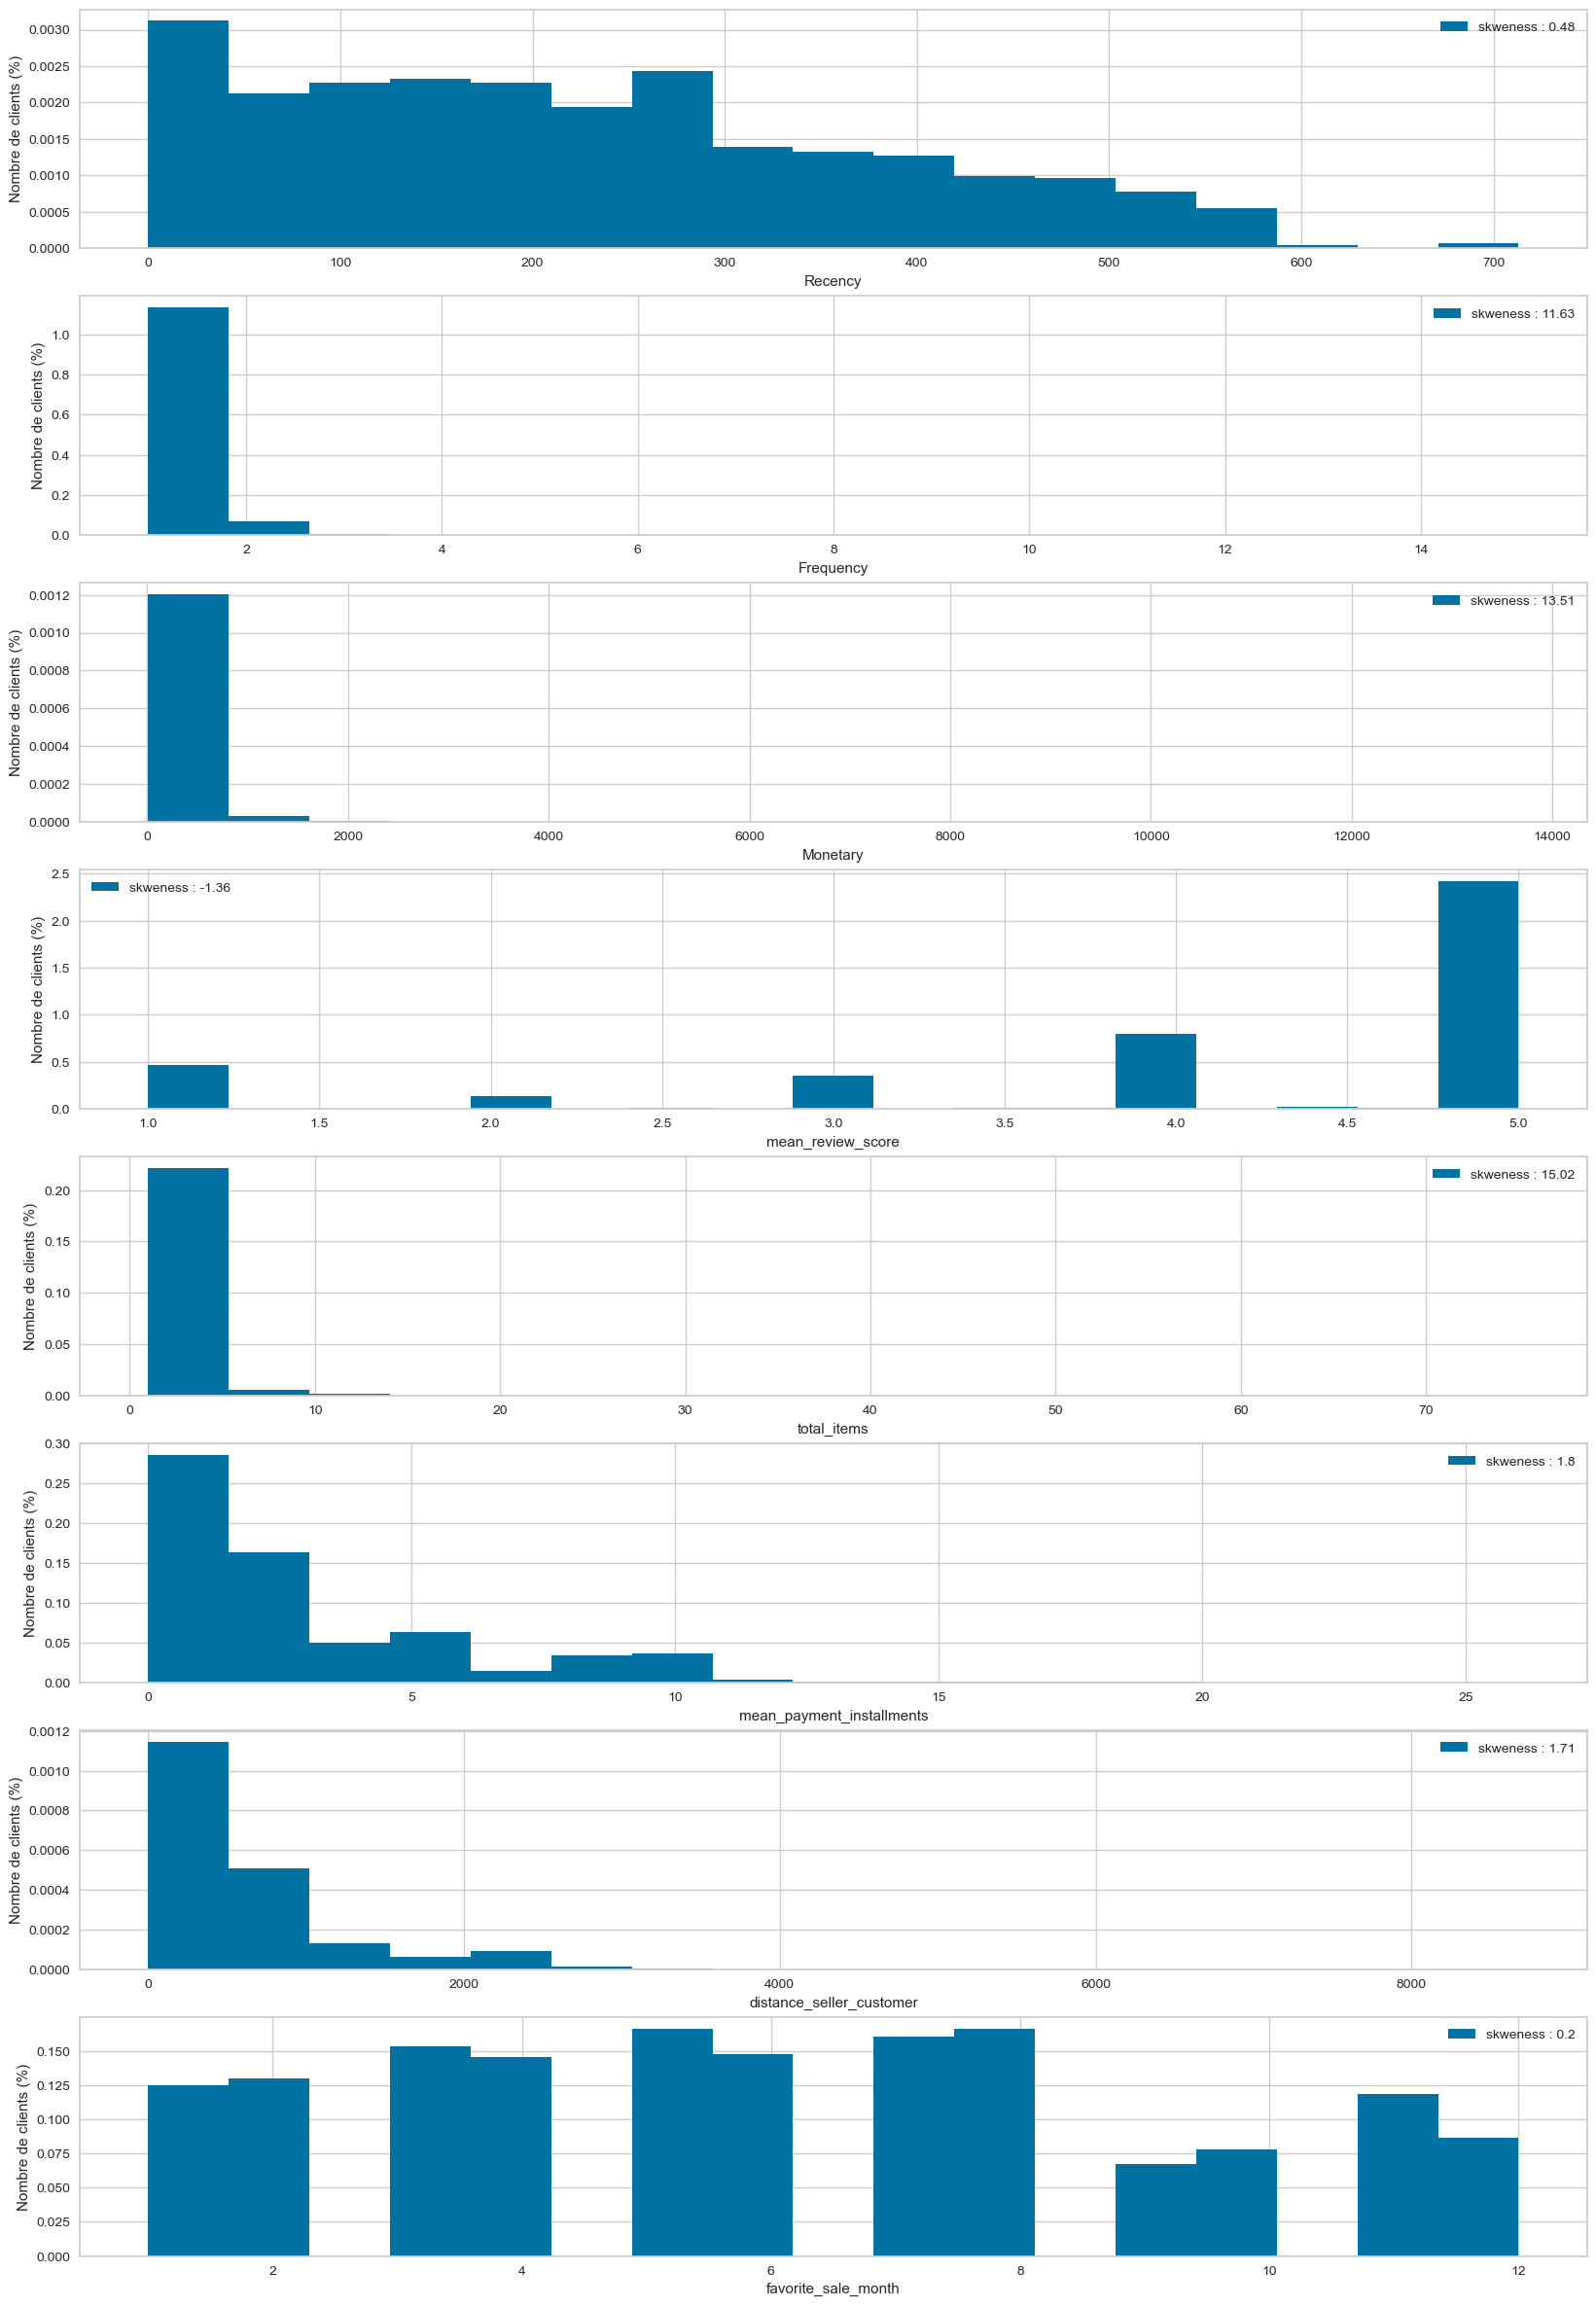

In [102]:
plot_hist(data_nf2,figsize=(20, 30))

In [103]:
data_nf2 = data_nf2.apply(lambda x:np.log(1 + x))

In [104]:
# Normalisation
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

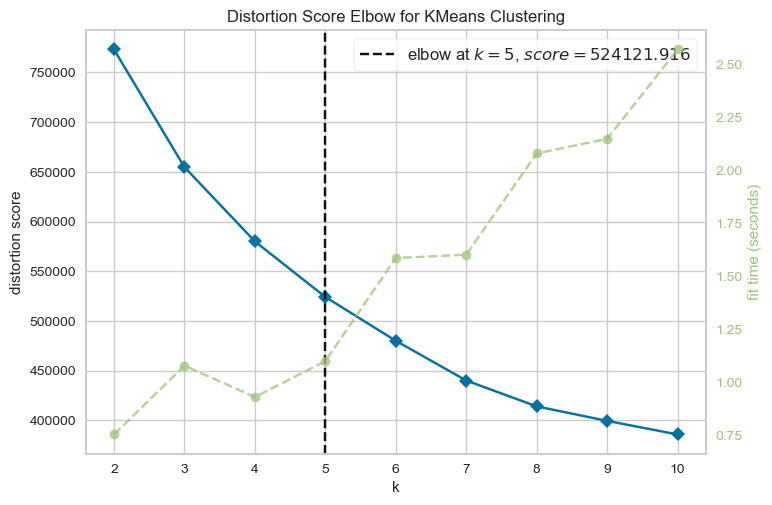

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [105]:
X = data_nf2.copy()
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

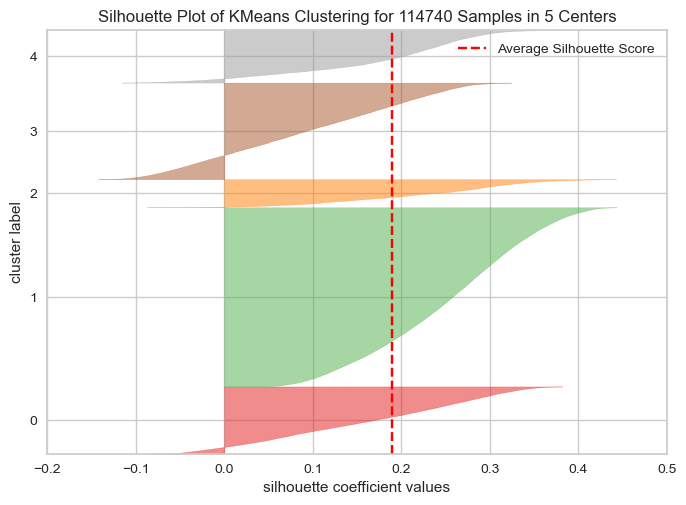

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 114740 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [106]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

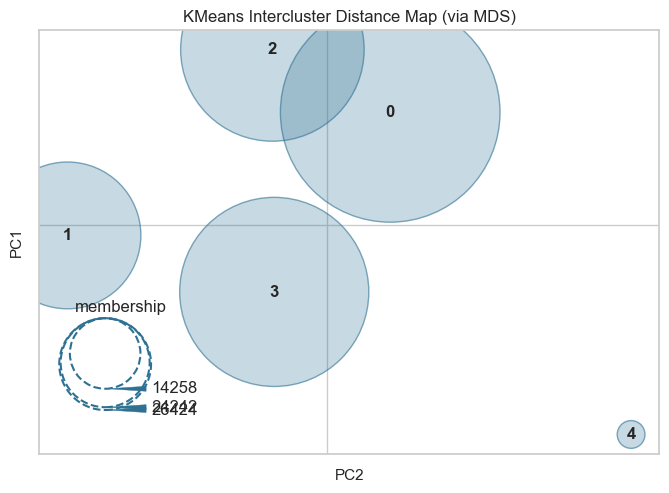

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [107]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [108]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
##### KMeans Pipeline with best K
kmeans_model = Pipeline([
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X_scaled)
X_scaled["kmeans_label"] = kmeans_model.named_steps['kmeans'].labels_
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

Recency  Frequency  Monetary  mean_review_score  total_items  \
kmeans_label                                                                  
0            -0.046840  -0.247760 -0.579206           0.333860    -0.278693   
1             0.181186  -0.247813  0.254356          -2.332014     0.232774   
2             0.160435  -0.249203 -0.369251           0.364872    -0.382443   
3             0.176058  -0.249203  0.923895           0.329961     0.368023   
4            -1.851892   3.496700  0.086687           0.084939     1.403093   

              mean_payment_installments  distance_seller_customer  \
kmeans_label                                                        
0                             -0.424727                 -1.695499   
1                              0.089017                  0.197520   
2                             -0.503740                  0.417229   
3                              1.119718                  0.283089   
4                              0.208397                  0.055692   

              favorite_sale_month  
kmeans_label                       
0                        0.049462  
1                       -0.108712  
2                       -0.033667  
3                        0.090240  
4                       -0.011702

In [109]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

# Clustering avec toutes les variables (inclus catégories de produits)

In [138]:
data=df.copy()
data=data.rename(columns={"nb_orders": "Frequency", "mean_price_order": "Monetary","order_mean_delay":"Recency"})
data=data.drop(columns=['customer_unique_id'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114740 entries, 0 to 114739
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Frequency                     114740 non-null  int64  
 1   distance_seller_customer      114740 non-null  float64
 2   mean_product_volume_cm3       114740 non-null  float64
 3   mean_payment_installments     114740 non-null  float64
 4   mean_review_score             114740 non-null  float64
 5   mean_delivery_days            114740 non-null  float64
 6   favorite_sale_month           114740 non-null  int64  
 7   order_purchase_timestamp      114740 non-null  object 
 8   dernier_achat                 114740 non-null  object 
 9   payment_type                  114740 non-null  object 
 10  books_cds_media               114740 non-null  float64
 11  fashion_clothing_accessories  114740 non-null  float64
 12  flowers_gifts                 114740 non-nul

## Preprocessing

In [139]:
categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

['order_purchase_timestamp', 'dernier_achat', 'payment_type', 'customer_state']

In [140]:
# Encodage binaire de l'état des acheteurs, Sao Paulo ou Non
data.loc[data["customer_state"] != "SP", "customer_state"] = 0
data.loc[data["customer_state"] == "SP", "customer_state"] = 1

data["customer_state"] = data["customer_state"].astype('float64')

# Encodage binaire du type de payment, Credit card ou Non
data.loc[data["payment_type"] != "credit_card", "payment_type"] = 0.0
data.loc[data["payment_type"] == "credit_card", "payment_type"] = 1.0


data["payment_type"] = data["payment_type"].astype('float64')

In [141]:
numerical_features = list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['Frequency',
 'distance_seller_customer',
 'mean_product_volume_cm3',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'favorite_sale_month',
 'payment_type',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'groceries_food_drink',
 'health_beauty',
 'home_furniture',
 'other',
 'sport',
 'technology',
 'toys_baby',
 'total_items',
 'Recency',
 'freight_ratio',
 'Monetary',
 'customer_state']

In [142]:
# Normalisation
scaler = MinMaxScaler()


preprocessor = ColumnTransformer([
     ('scaler', scaler, numerical_features)])

In [144]:
X = data.copy()
X.dtypes

Frequency                         int64
distance_seller_customer        float64
mean_product_volume_cm3         float64
mean_payment_installments       float64
mean_review_score               float64
mean_delivery_days              float64
favorite_sale_month               int64
order_purchase_timestamp         object
dernier_achat                    object
payment_type                    float64
books_cds_media                 float64
fashion_clothing_accessories    float64
flowers_gifts                   float64
groceries_food_drink            float64
health_beauty                   float64
home_furniture                  float64
other                           float64
sport                           float64
technology                      float64
toys_baby                       float64
total_items                     float64
Recency                         float64
freight_ratio                   float64
Monetary                        float64
customer_state                  float64


In [145]:
categorical_features = list(X.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

['order_purchase_timestamp', 'dernier_achat']

In [148]:
X=X.drop(columns=categorical_features)
X.dtypes

Frequency                         int64
distance_seller_customer        float64
mean_product_volume_cm3         float64
mean_payment_installments       float64
mean_review_score               float64
mean_delivery_days              float64
favorite_sale_month               int64
payment_type                    float64
books_cds_media                 float64
fashion_clothing_accessories    float64
flowers_gifts                   float64
groceries_food_drink            float64
health_beauty                   float64
home_furniture                  float64
other                           float64
sport                           float64
technology                      float64
toys_baby                       float64
total_items                     float64
Recency                         float64
freight_ratio                   float64
Monetary                        float64
customer_state                  float64
dtype: object

In [149]:
X = X.apply(lambda x:np.log(1 + x))

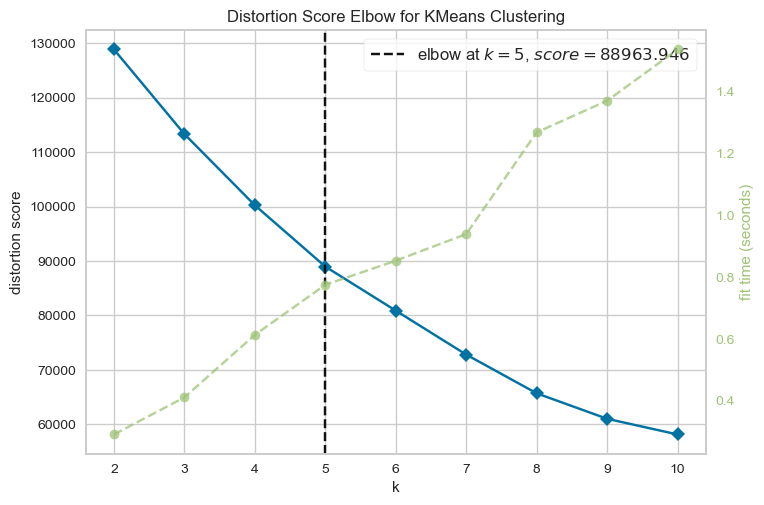

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [150]:

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()



### Coefficient de silhouette
Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

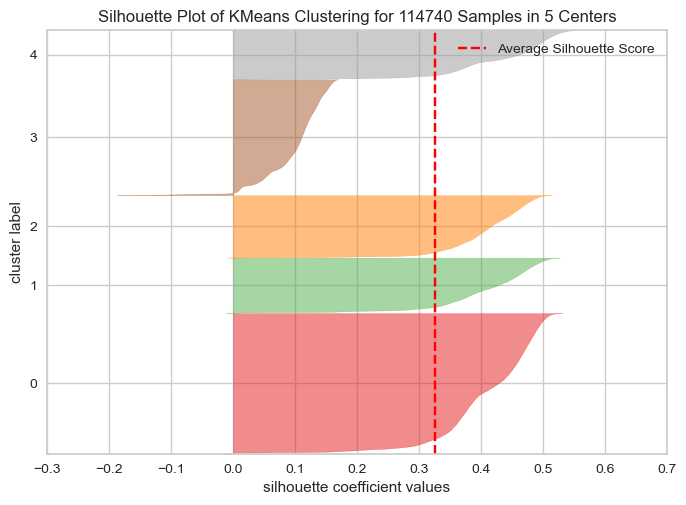

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 114740 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [151]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :

- Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
- Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

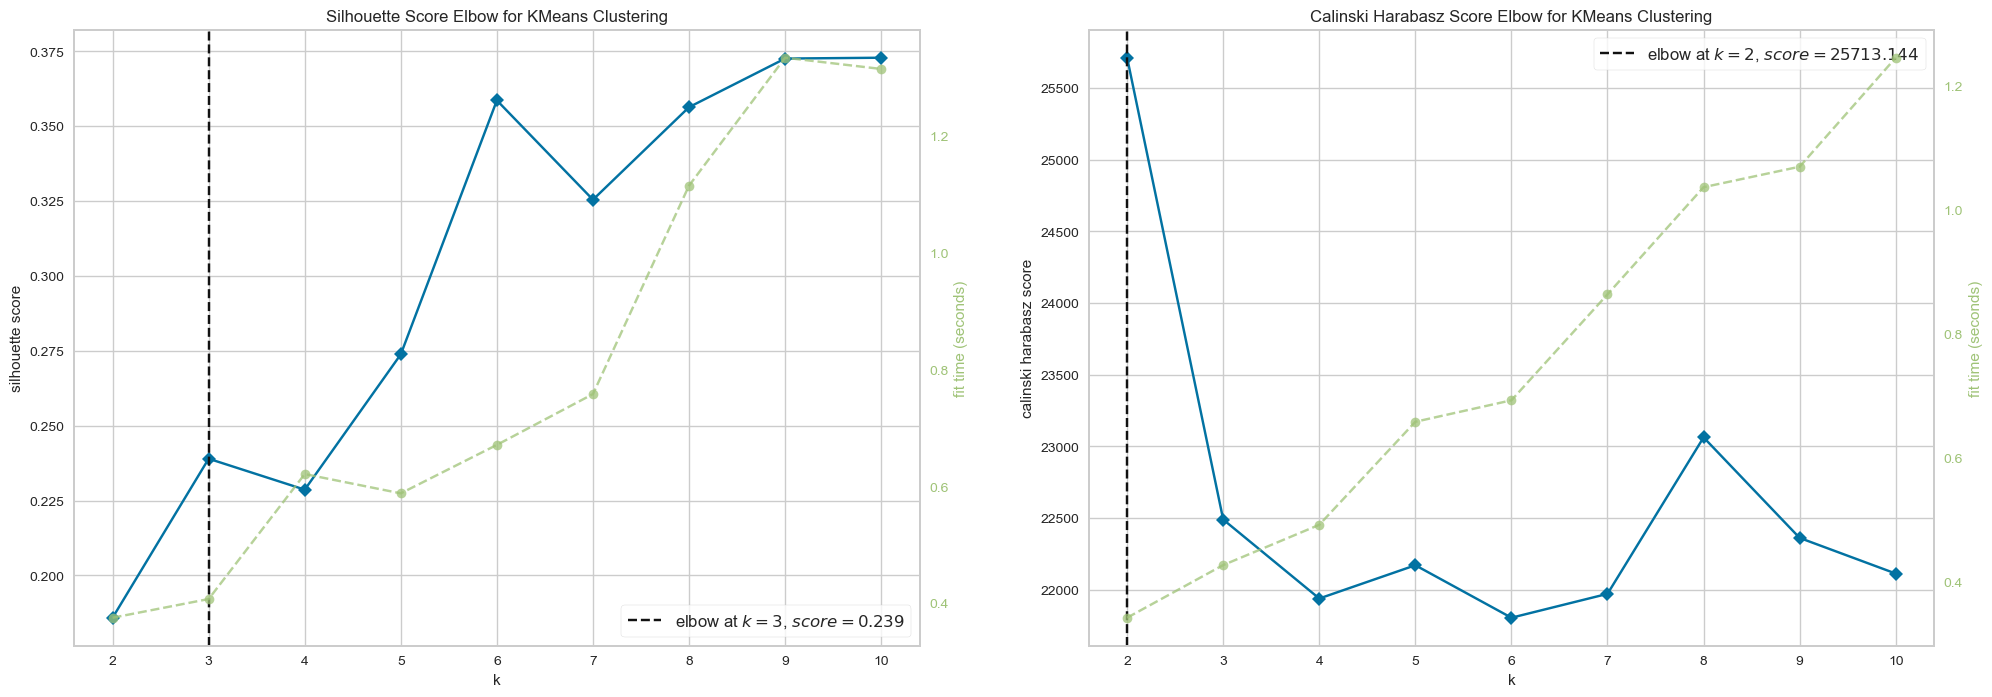

In [152]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

On remarque ici que pour la métrique silhouette score, le nombre de K est de 3. Pour le score Calinski Harabasz, le meilleur K est plus incertain. Les clusters ne sont donc pas optimaux. 


# Distances intercluster


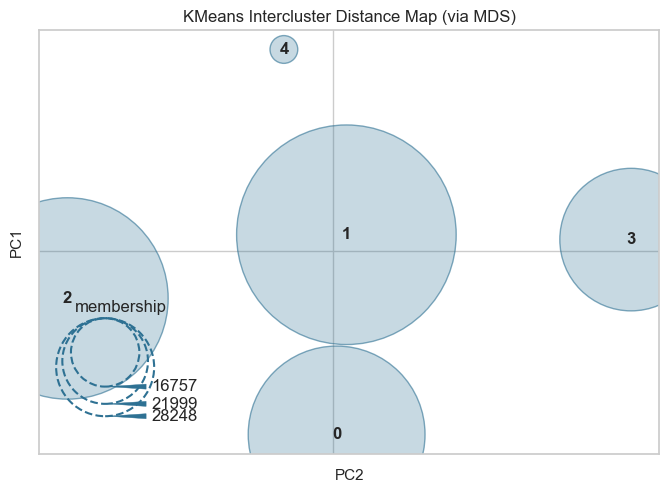

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [153]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.

## Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [154]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [155]:
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

kmeans_label  Frequency  distance_seller_customer  mean_product_volume_cm3  \
0             0   1.066762                641.884394              7435.673393   
1             1   1.111790                541.941786             22495.528528   
2             2   1.060794                580.566525             17910.668709   
3             3   1.062157                686.035733              5014.319869   
4             4   1.074459                602.019979             14030.693989   

   mean_payment_installments  mean_review_score  mean_delivery_days  \
0                   3.240095           4.189898           11.886738   
1                   3.601202           3.990417           12.857677   
2                   3.014882           4.140198           12.003463   
3                   2.444749           4.016439           13.060416   
4                   3.066602           4.174800           12.028576   

   favorite_sale_month  payment_type  books_cds_media  ...  home_furniture  \
0             6.081798      0.764003         0.000301  ...        0.004135   
1             6.056604      0.736479         0.000262  ...        0.981132   
2             5.855041      0.735517         0.000333  ...        0.006725   
3             5.700372      0.694056         0.000059  ...        0.002715   
4             6.257323      0.753419         0.029771  ...        0.001657   

      other     sport  technology  toys_baby  total_items     Recency  \
0  0.002556  0.003759    0.001804   0.001203     1.491241  216.061364   
1  0.005065  0.002152    0.002703   0.002965     2.241399  226.646196   
2  0.976495  0.002797    0.003329   0.002530     1.600080  208.588050   
3  0.001594  0.001240    0.988135   0.001299     1.678236  232.057464   
4  0.001275  0.271635    0.001402   0.227106     1.477481  236.895944   

   freight_ratio    Monetary  customer_state  
0       0.153840  183.488465             0.0  
1       0.174712  224.060834             0.0  
2       0.164052  240.063654             0.0  
3       0.192153  203.284382             0.0  
4       0.151082  192.943361             0.0  

[5 rows x 24 columns]

In [156]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

Frequency  distance_seller_customer  mean_product_volume_cm3  \
kmeans_label                                                                 
0              0.012580                  0.632957                 0.435633   
1              0.020210                  0.637707                 0.584784   
2              0.011381                  0.628926                 0.531503   
3              0.011528                  0.653011                 0.381109   
4              0.012542                  0.636062                 0.481430   

              mean_payment_installments  mean_review_score  \
kmeans_label                                                 
0                              0.385844           0.825552   
1                              0.400404           0.781813   
2                              0.363410           0.816168   
3                              0.322669           0.788373   
4                              0.371133           0.823955   

              mean_delivery_days  favorite_sale_month  payment_type  \
kmeans_label                                                          
0                       0.356904             0.611647      0.764003   
1                       0.377953             0.608336      0.736479   
2                       0.361110             0.589141      0.735517   
3                       0.382665             0.569613      0.694056   
4                       0.362338             0.622594      0.753419   

              books_cds_media  fashion_clothing_accessories  ...  \
kmeans_label                                                 ...   
0                    0.000352                      0.001249  ...   
1                    0.000306                      0.001521  ...   
2                    0.000390                      0.002809  ...   
3                    0.000069                      0.002285  ...   
4                    0.029816                      0.119770  ...   

              home_furniture     other     sport  technology  toys_baby  \
kmeans_label                                                              
0                   0.004918  0.003054  0.004429    0.002142   0.001427   
1                   0.984584  0.006144  0.002565    0.003244   0.003549   
2                   0.008043  0.980634  0.003326    0.003966   0.002978   
3                   0.003261  0.001948  0.001457    0.990265   0.001529   
4                   0.002085  0.001605  0.272426    0.001709   0.227874   

              total_items   Recency  freight_ratio  Monetary  customer_state  
kmeans_label                                                                  
0                0.041464  0.752786       0.352831  0.338812             0.0  
1                0.083173  0.755995       0.399184  0.359854             0.0  
2                0.048657  0.749934       0.374820  0.348731             0.0  
3                0.050040  0.776520       0.433045  0.310199             0.0  
4                0.040353  0.777621       0.347538  0.347120             0.0  

[5 rows x 23 columns]

Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [157]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

On observe que la plupart des clusters se forment sans inclure les catégories de produits. On a uniquement le cluster 3 qui est fortement influencé par l'achats de livres, de média ou de la mode.  . Le poids des features de produits masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables.

# Clusturing sans les catégories de produits

In [158]:
categories_col = ['books_cds_media','fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X_bis = X.drop(categories_col, axis=1)
X_bis = X_bis.rename(columns={"nb_orders": "Frequency", "mean_price_order": "Monetary","order_mean_delay":"Recency"})
X_bis.head(6)

Frequency  distance_seller_customer  mean_product_volume_cm3  \
0   0.693147                  4.714640                 8.938138   
1   0.693147                  3.142786                 8.546558   
2   0.693147                  6.249857                10.686270   
3   0.693147                  7.816936                 6.952729   
4   0.693147                  5.046696                 6.270988   
5   0.693147                  3.338963                 9.016998   

   mean_payment_installments  mean_review_score  mean_delivery_days  \
0                   2.197225           1.791759            1.945910   
1                   0.693147           1.609438            1.386294   
2                   2.197225           1.386294            3.295837   
3                   1.609438           1.609438            3.044522   
4                   1.945910           1.791759            2.639057   
5                   2.197225           1.609438            1.098612   

   favorite_sale_month  payment_type  total_items   Recency  freight_ratio  \
0             1.791759      0.693147     0.693147  4.718499       0.076961   
1             1.791759      0.693147     0.693147  4.744932       0.207014   
2             1.386294      0.693147     0.693147  6.287859       0.157004   
3             2.397895      0.693147     0.693147  5.774552       0.254642   
4             2.484907      0.693147     0.693147  5.666427       0.076961   
5             1.609438      0.693147     0.693147  4.990433       0.067659   

   Monetary  customer_state  
0  4.962145             0.0  
1  3.338967             0.0  
2  4.468434             0.0  
3  3.798182             0.0  
4  5.287711             0.0  
5  5.123845             0.0

In [159]:
#sauvegarde pour étude de la stabilité 
X_bis.to_csv("olist-final.csv",index=True)

In [160]:
hi=pd.read_csv('olist-final.csv')
hi.head()

Unnamed: 0  Frequency  distance_seller_customer  mean_product_volume_cm3  \
0           0   0.693147                  4.714640                 8.938138   
1           1   0.693147                  3.142786                 8.546558   
2           2   0.693147                  6.249857                10.686270   
3           3   0.693147                  7.816936                 6.952729   
4           4   0.693147                  5.046696                 6.270988   

   mean_payment_installments  mean_review_score  mean_delivery_days  \
0                   2.197225           1.791759            1.945910   
1                   0.693147           1.609438            1.386294   
2                   2.197225           1.386294            3.295837   
3                   1.609438           1.609438            3.044522   
4                   1.945910           1.791759            2.639057   

   favorite_sale_month  payment_type  total_items   Recency  freight_ratio  \
0             1.791759      0.693147     0.693147  4.718499       0.076961   
1             1.791759      0.693147     0.693147  4.744932       0.207014   
2             1.386294      0.693147     0.693147  6.287859       0.157004   
3             2.397895      0.693147     0.693147  5.774552       0.254642   
4             2.484907      0.693147     0.693147  5.666427       0.076961   

   Monetary  customer_state  
0  4.962145             0.0  
1  3.338967             0.0  
2  4.468434             0.0  
3  3.798182             0.0  
4  5.287711             0.0

In [161]:
X_bis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114740 entries, 0 to 114739
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Frequency                  114740 non-null  float64
 1   distance_seller_customer   114740 non-null  float64
 2   mean_product_volume_cm3    114740 non-null  float64
 3   mean_payment_installments  114740 non-null  float64
 4   mean_review_score          114740 non-null  float64
 5   mean_delivery_days         114740 non-null  float64
 6   favorite_sale_month        114740 non-null  float64
 7   payment_type               114740 non-null  float64
 8   total_items                114740 non-null  float64
 9   Recency                    114740 non-null  float64
 10  freight_ratio              114740 non-null  float64
 11  Monetary                   114740 non-null  float64
 12  customer_state             114740 non-null  float64
dtypes: float64(13)
memory usage: 

### Étude des variables

In [162]:
def plot_hist(rfm, figsize=(20, 10)):

    plt.figure(1, figsize=figsize)

    for i, col in enumerate(rfm):
        plt.subplot(len(rfm.columns), 1, i + 1)
        plt.hist(rfm[col],
                 bins=int(1 + np.log2(len(rfm))),
                 label='skweness : ' + str(round(rfm[col].skew(), 2)),
                 density=True)
        plt.ylabel("Nombre de clients (%)")
        plt.xlabel(col)
        plt.legend()
    plt.show()

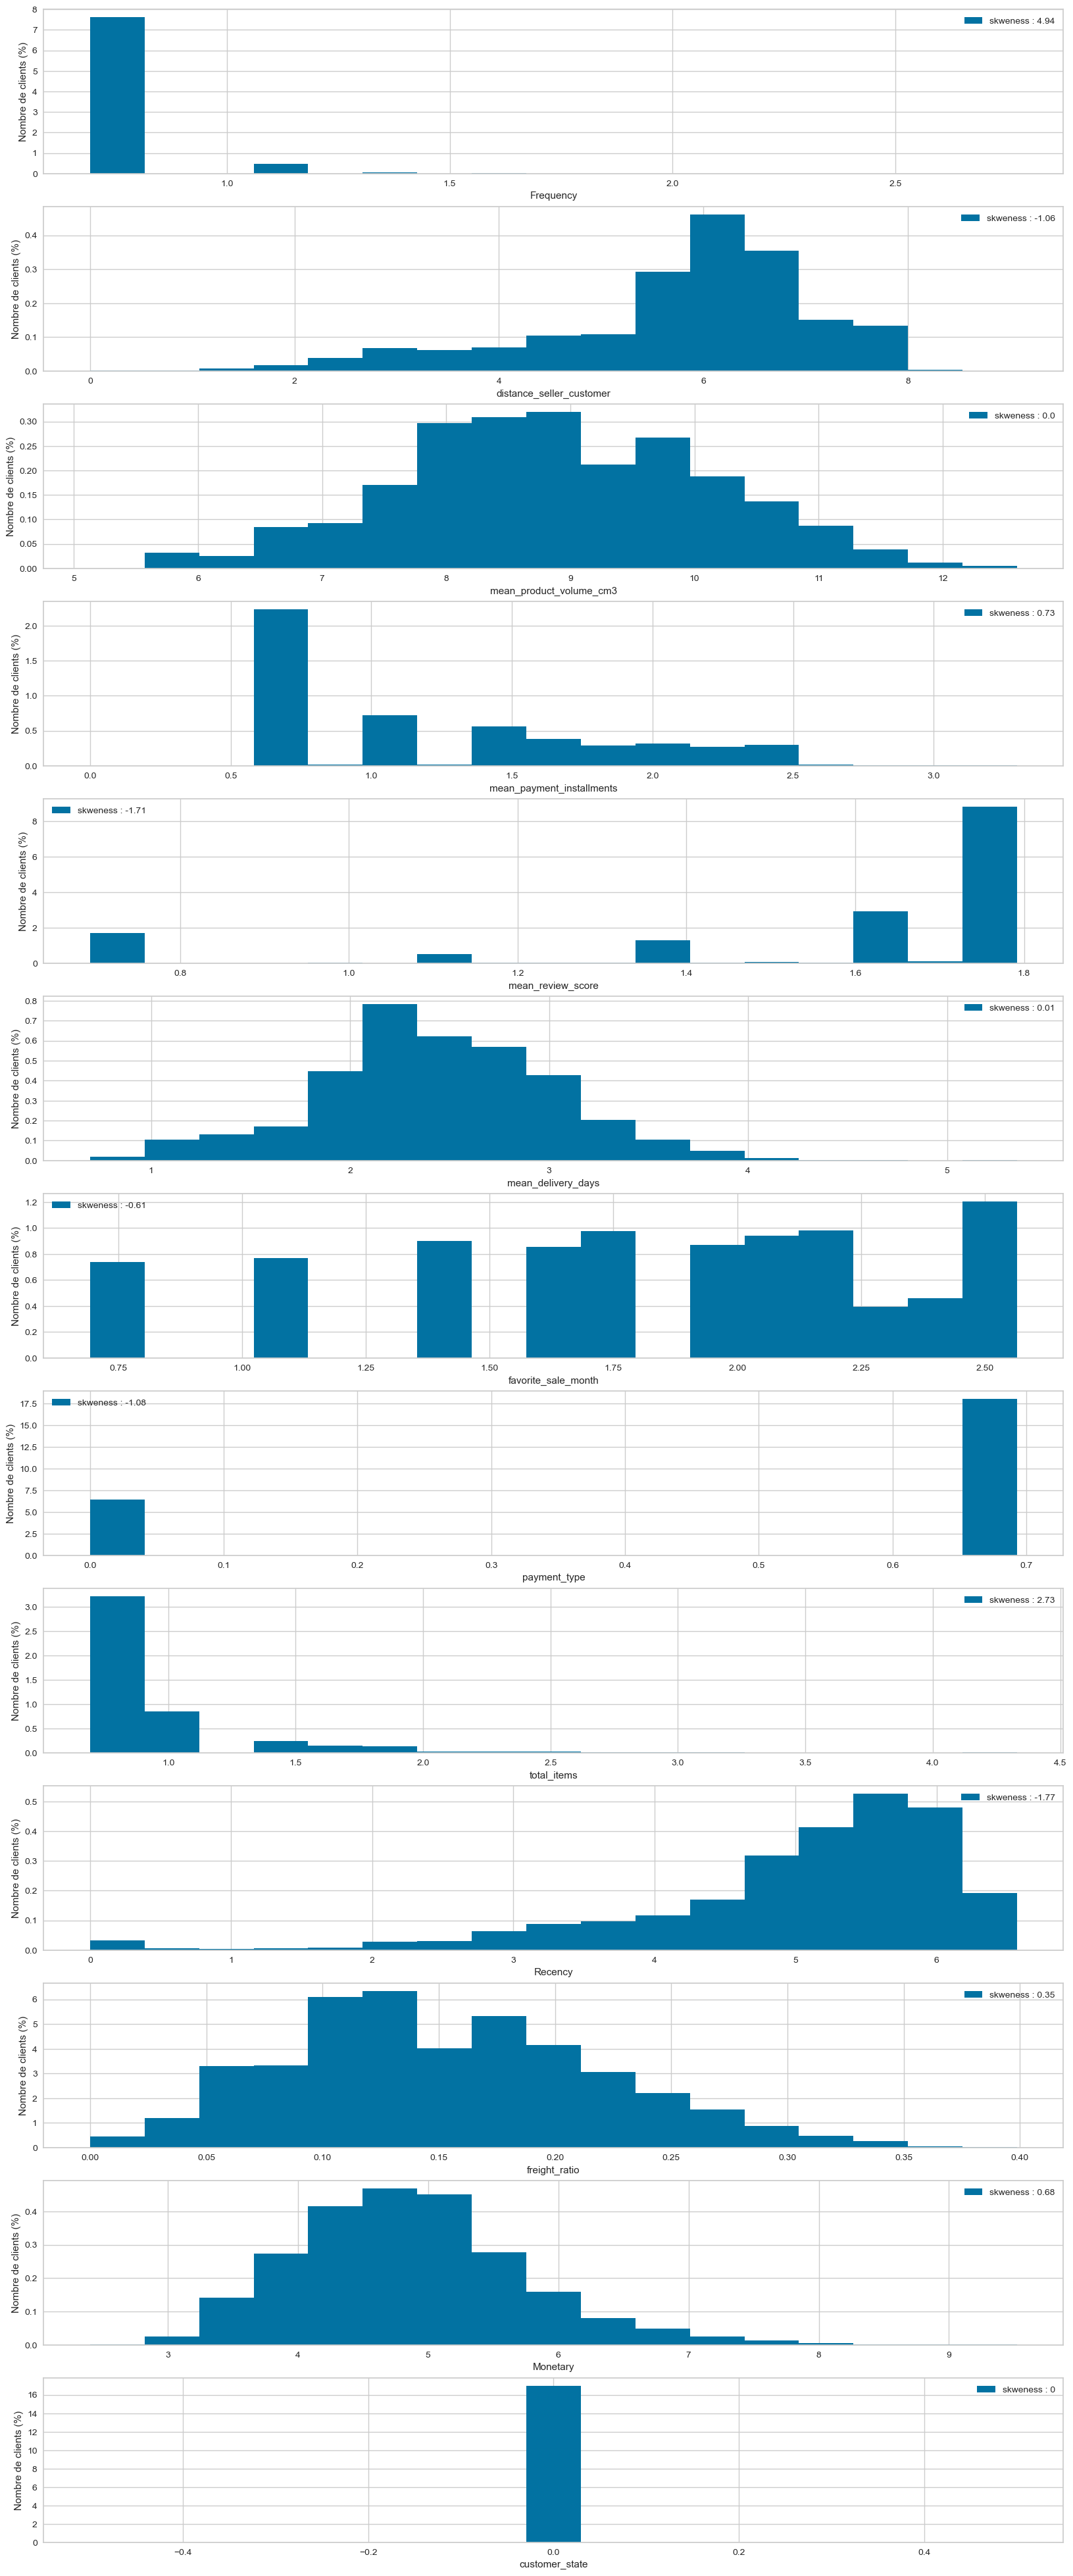

In [163]:
# Affichage de l'histogramme de chacune des variables
plot_hist(X_bis, figsize=(20, 50))

In [164]:
X_bis_plus = X_bis.copy()

In [165]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)
    
    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()


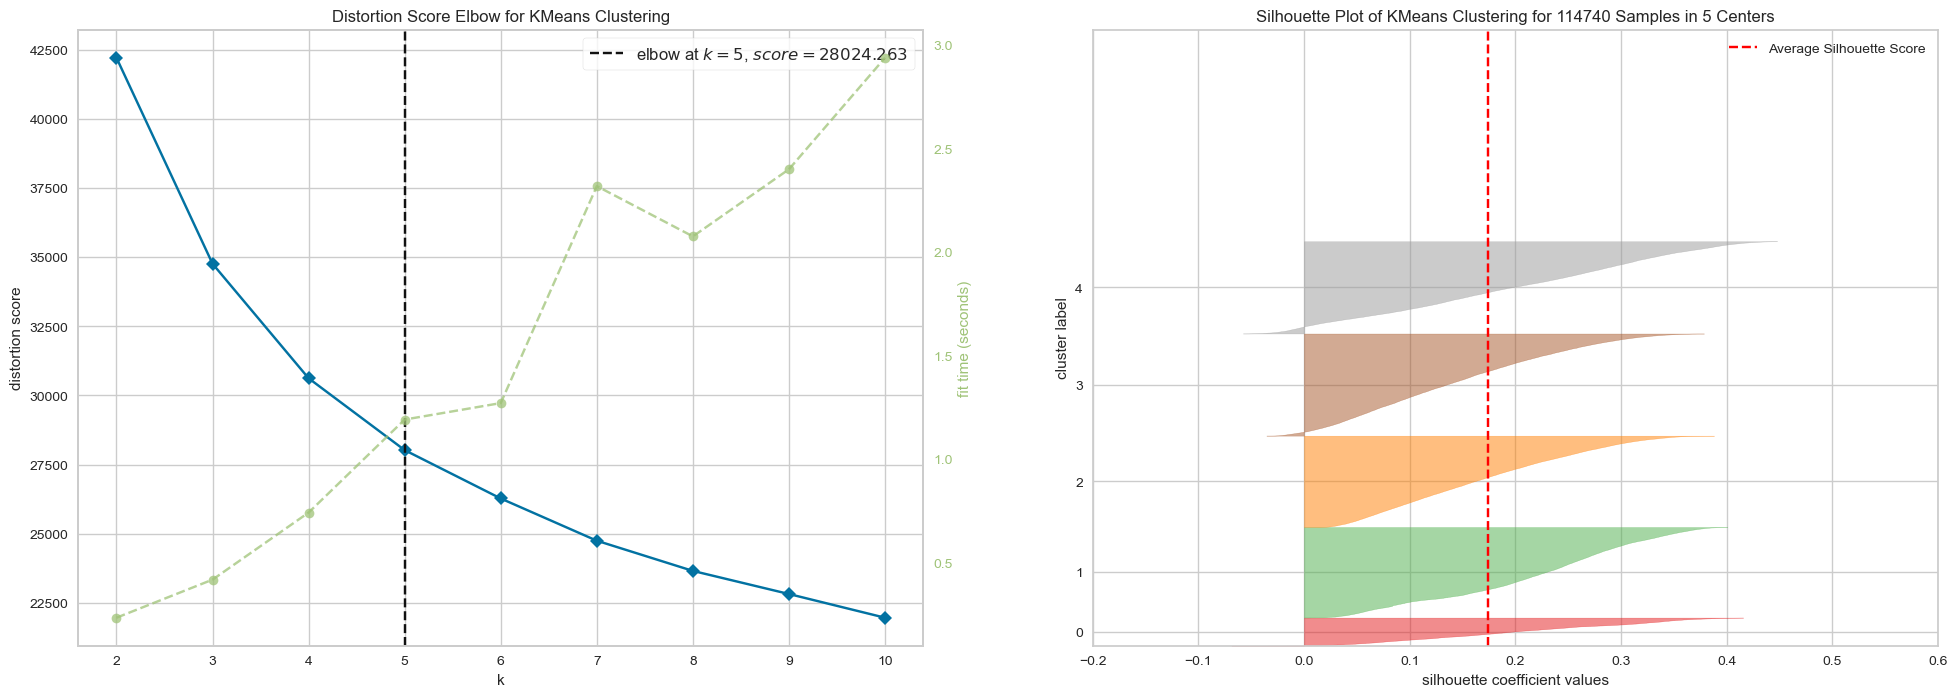

In [166]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_bis_plus, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [167]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis_plus)

# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis_plus)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis_plus.index, columns=X_bis_plus.columns)
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

# Group by cluster
X_scaled_clusters_bis = X_scaled_bis.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters_bis,
            group="kmeans_label")

## Interprétation métier des clusters
- Cluster 0 : Clients avec crédit et fidèles
Clients de fin d'année. Clients qui payent en plusieurs fois avec crédit principalement, il achètent dans une période bien précise car ils ont un favorite sale month élevé. Ils notent généralement les produits positivement. 
- Cluster 1 : Clients champions
Clients réguliers et qui achètent avec un monétary assez élevé ainsi qu'un bon nombre d'items. de fin d'année. Ces clients sont géographiquement un peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons.

- Cluster 2 : Clients occasionnels
Regroupe les clients qui utilisent des cartes de crédits, payent en plusieurs échéances et qui attendent beaucoup pour recevoir leur commande. Ils commandent en général des produits volumimeux. Ie ne commandent pas fréquemment. Les avis sont très positifs. 

- Cluster 3: Clients à grand risque
Ce sont des clients mécontants (les avis sont mauvais). Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont acheté des produits volumineux et payent sur plusieurs échéances par crédit .Le nombre de commandes passées sur le site est moyen.

- Cluster 4 : Clients nouveaux potentiels loyalistes
Ces clients ont passé un nombre important de commandes. ils paient comptant pour un montant élevé de commande. Ils sont géographiquement pas trop éloignés. Ils dépensent beaucoup mais sont peu fréquents car ils sont nouveaux. 


Nous allons à présent réaliser une réduction dimensionnelle pour vérifier si le clustering est réalisable sur un nombre réduit de variables sans perturber les groupes.

## Réduction dimensionnelle - PCA

Nous allons réaliser une Analyse en Composantes Principales pour vérifier s'il est possible de catégoriser nos clients avec moins de variables. L'objectif étant de conserver une inertie de 95%.

In [168]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis_plus)
X_projected = pca.transform(X_bis_plus)

# Eboulis des valeurs propres

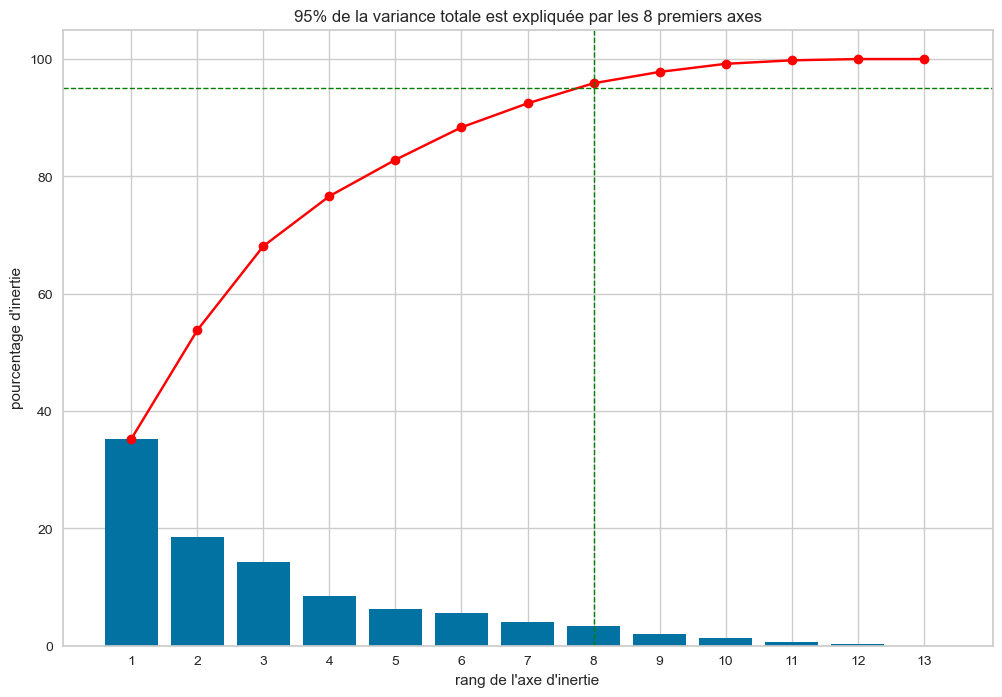

In [169]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)


# Cercle des corrélations

In [170]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 
            
            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            
            count+=1
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

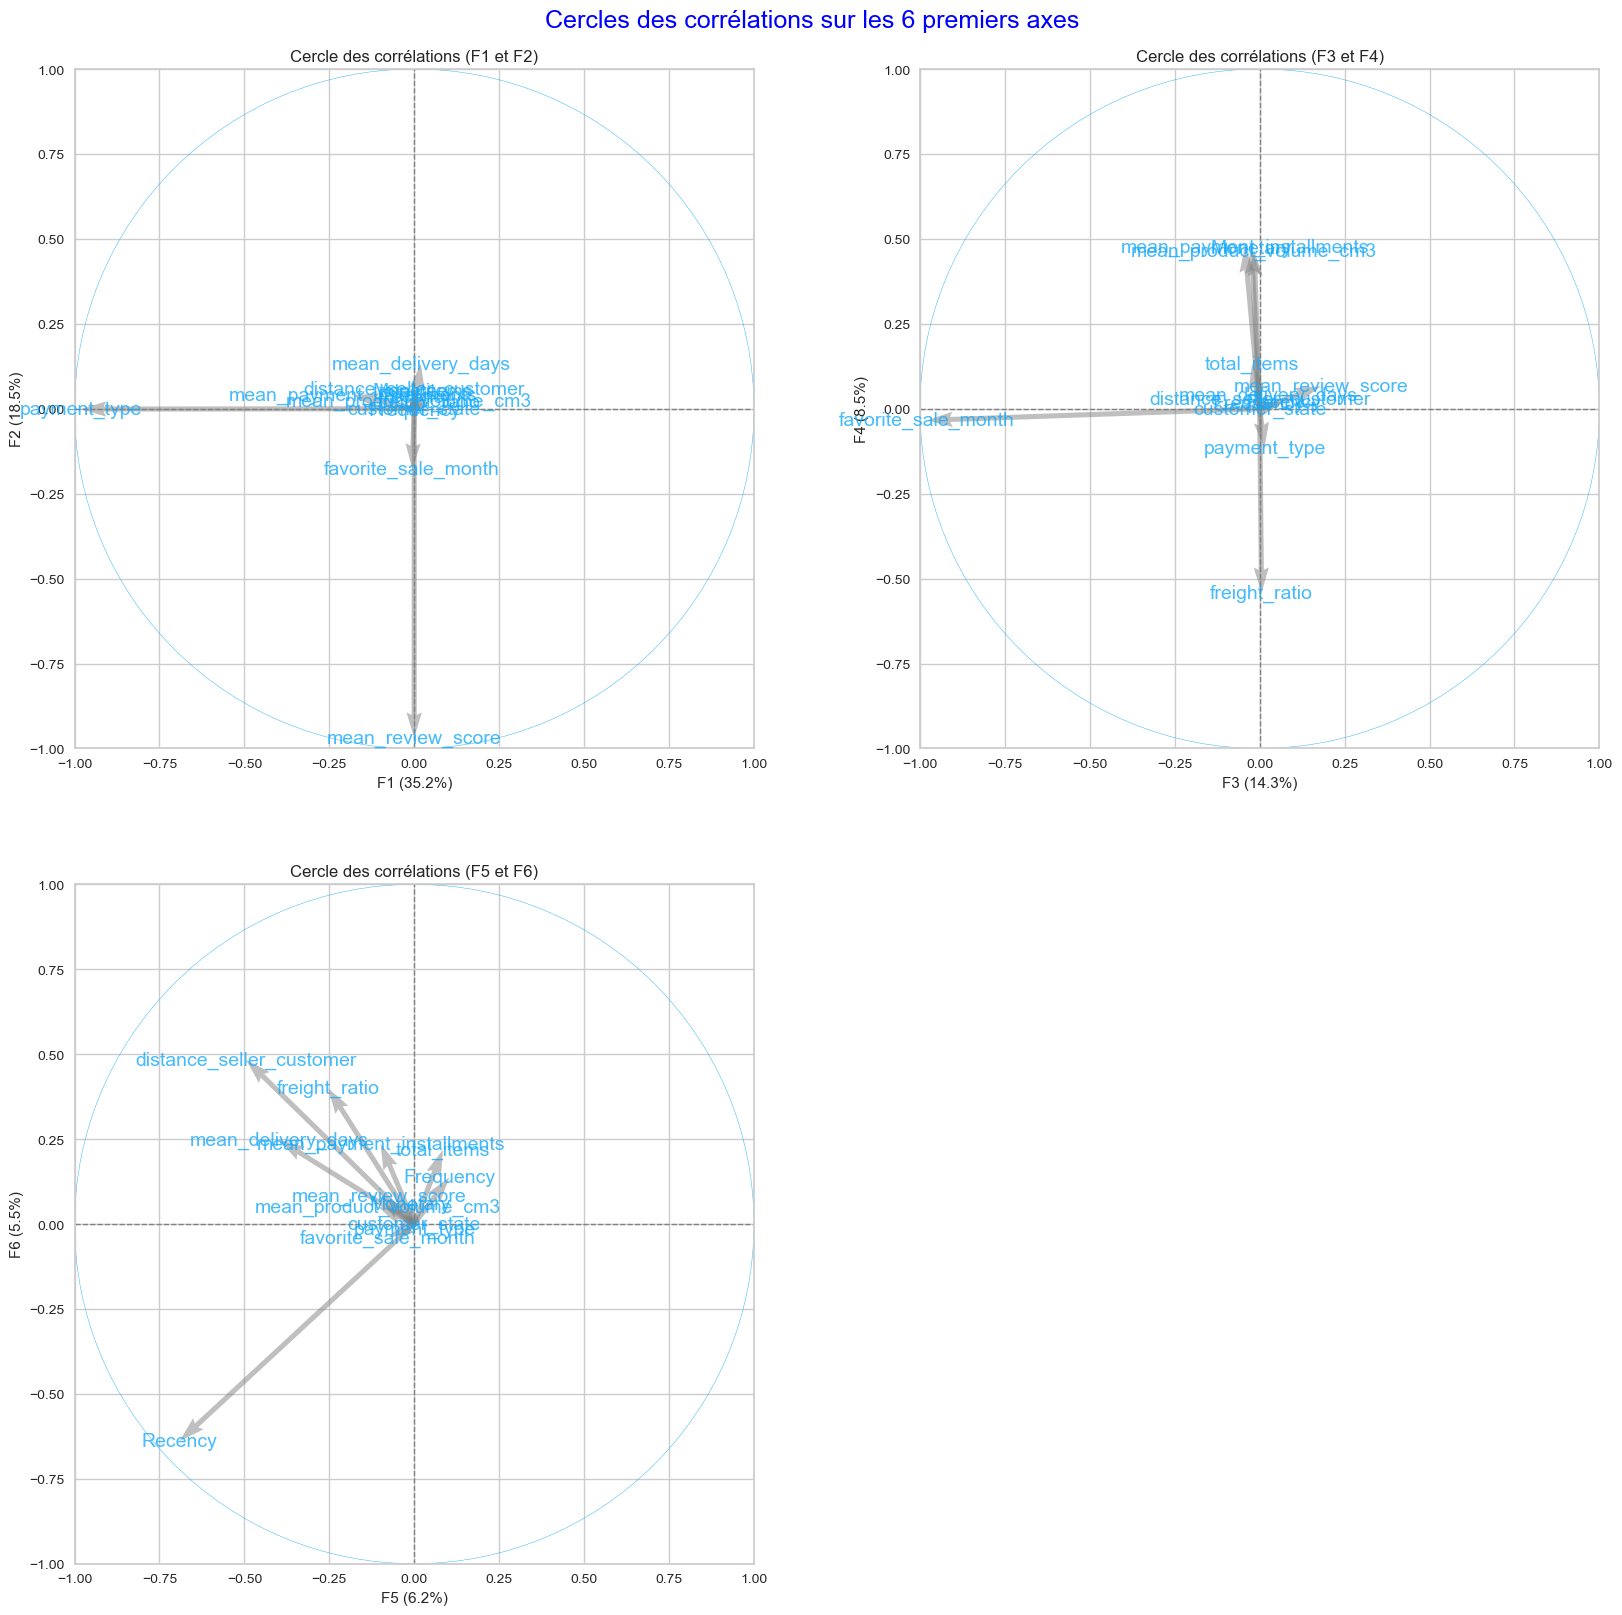

In [171]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(X_bis.columns))

On peut ainsi voir parfaitement les variables qui contribuent le plus à chaque axe. Par exemple,

- la variable synthétique F2 représentera les périodes d'achats.

- La variable synthétique F4 quant à elle représente l'aspect géographique.

Nous allons donc intégrer à notre pipeline Kmeans une PCA sur 4 composantes pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation.

## K-Means après réduction de dimensions

In [172]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:3])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_bis["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_bis.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

Frequency  distance_seller_customer  \
kmeans_label_pca                                        
0                  0.014202                  0.635541   
1                  0.015976                  0.636037   
2                  0.008790                  0.658727   
3                  0.016165                  0.633376   
4                  0.012748                  0.652513   

                  mean_product_volume_cm3  mean_payment_installments  \
kmeans_label_pca                                                       
0                                0.502085                   0.399548   
1                                0.495739                   0.257973   
2                                0.511584                   0.440434   
3                                0.503338                   0.418026   
4                                0.502593                   0.259432   

                  mean_review_score  mean_delivery_days  favorite_sale_month  \
kmeans_label_pca                                                               
0                          0.913787            0.374786             0.281217   
1                          0.923618            0.373133             0.606456   
2                          0.082392            0.436922             0.589988   
3                          0.927326            0.340989             0.781341   
4                          0.092677            0.448846             0.584868   

                  payment_type  total_items   Recency  freight_ratio  \
kmeans_label_pca                                                       
0                          1.0     0.040673  0.800730       0.370084   
1                          0.0     0.079161  0.763931       0.403945   
2                          1.0     0.078862  0.771196       0.387471   
3                          1.0     0.042720  0.740612       0.371268   
4                          0.0     0.122366  0.779705       0.410273   

                  Monetary  customer_state  
kmeans_label_pca                            
0                 0.337529             0.0  
1                 0.344879             0.0  
2                 0.370557             0.0  
3                 0.339563             0.0  
4                 0.382106             0.0

In [173]:
X_scaled_clusters_pca.to_csv("olist-final-pca.csv",index=True)

In [174]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

5

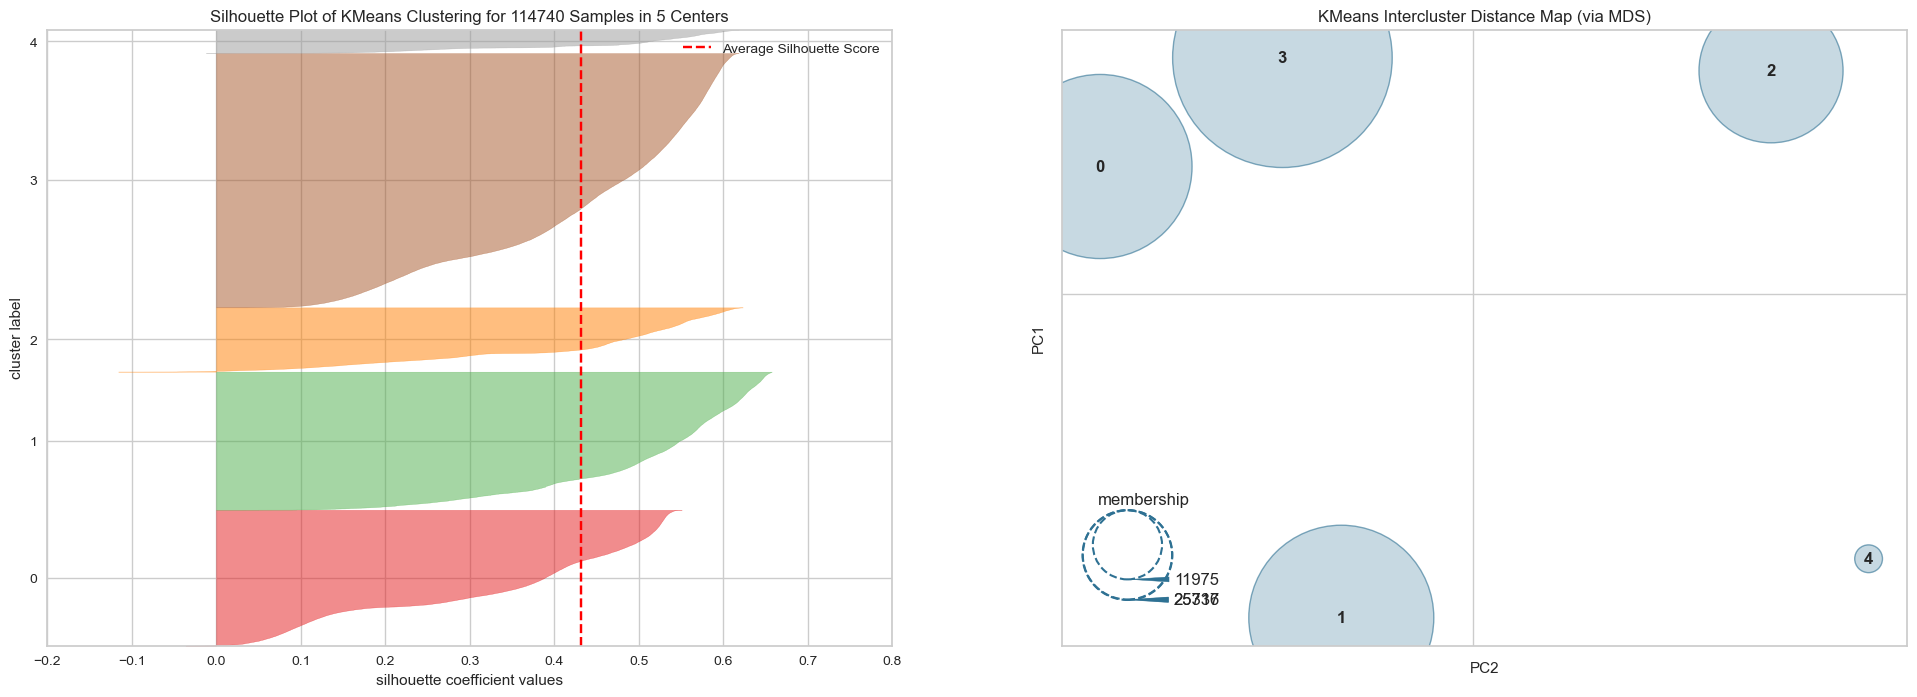

In [175]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:4], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

On remarque donc ici que la réduction de dimenssion offre les mêmes axes de segmentation. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter notre fichier client, ce d'autant que les scores silhouette sont ici meilleurs comparés au données brutes.

In [180]:
# Calcul des différentes variables pour le clustering RFM ++
rfm_plus_1 = X_scaled_clusters_pca.copy()
# Initilisation d'un KMeans
kmeans_plus = KMeans(n_clusters=5, init='k-means++', random_state=42)
# Clustering sur les données pour la période 1
clusters = kmeans_plus.fit_predict(X_scaled_clusters_pca)
rfm_plus_1['clusters_plus'] = clusters


# Etiquette des catégories pour le clustering RFM ++
categories_plus = [
                    'Clients à crédit mais potentiels',
                    'Clients occasionnels',
                    'Clients prometteurs',
                    'Clients à risque',
                    'Clients potentiels loyalistes'
                ]
# Renommage des différents clusters RFM ++
rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               0, "clusters_plus"] = 'Clients à crédit mais potentiels'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               1, "clusters_plus"] = 'Clients à risque'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               2, "clusters_plus"] = 'Clients prometteurs'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               3, "clusters_plus"] = 'Clients occasionnels'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               4, "clusters_plus"] = 'Clients potentiels loyalistes'

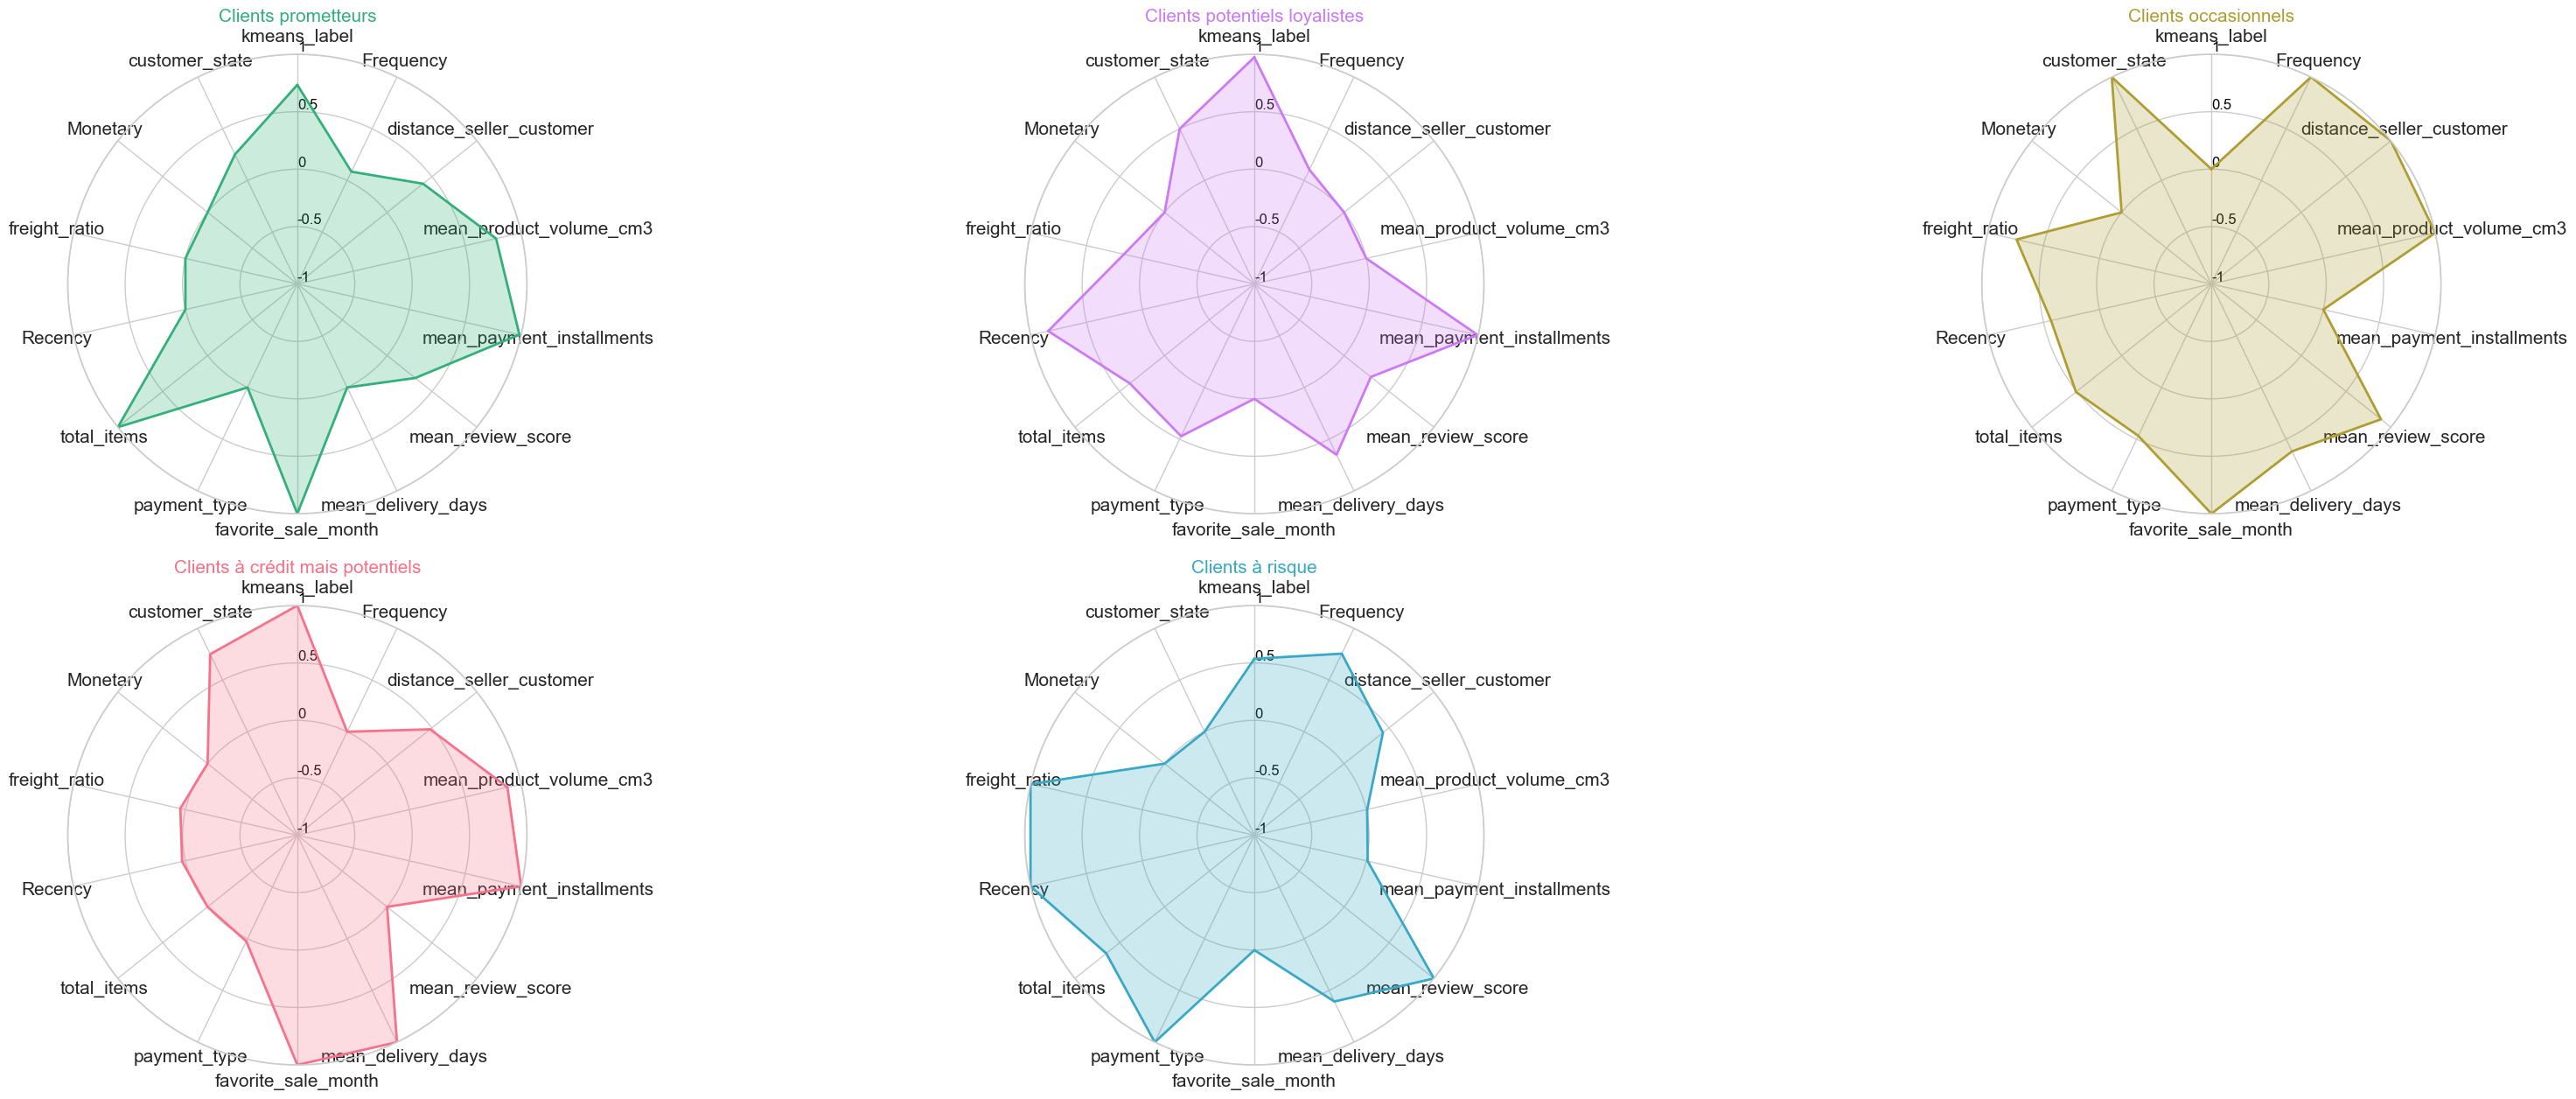

In [181]:
# Liste des couleurs pour chaque segment
palette_plus = sns.color_palette("husl", rfm_plus_1['clusters_plus'].nunique())
colors_plus = {label: color for label, color in zip(categories_plus,
               palette_plus.as_hex())}
# Radar plot des clients moyens pour chaque cluster RFM ++
radar_plot(rfm_plus_1,
           'clusters_plus',
           colors_plus,
           sub_plot=[2, 3],
           figsize=(40, 15))

# Clusturing hierarchique

### Dendogramme

Un dendrogramme est un arbre dont les feuilles sont les points d'un jeu de données. Chaque nœud de l'arbre représente un cluster (les feuilles sont des clusters contenant un point chacun). Les clusters qui ont le même parent sont agglomérés pour former ce cluster parent. La longueur des U est proportionnelle à la distance entre les deux clusters qu'ils connectent.

In [187]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby',
                  'order_purchase_timestamp',
                  'dernier_achat'
                                   ]

In [188]:
data_bis = data.drop(categories_col ,axis = 1)

In [189]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, data_bis)])

In [190]:
X = data_bis.copy()
X.head(10)

Frequency  distance_seller_customer  mean_product_volume_cm3  \
0          1                110.568636                   7616.0   
1          1                 22.168333                   5148.0   
2          1                516.938836                  43750.0   
3          1               2481.287188                   1045.0   
4          1                154.507887                    528.0   
5          1                 27.189874                   8241.0   
6          1                101.546094                    816.0   
7          1                503.683955                  15059.0   
8          1                503.683955                  15059.0   
9          1                246.720484                   6600.0   

   mean_payment_installments  mean_review_score  mean_delivery_days  \
0                        8.0                5.0                 6.0   
1                        1.0                4.0                 3.0   
2                        8.0                3.0                26.0   
3                        4.0                4.0                20.0   
4                        6.0                5.0                13.0   
5                        8.0                4.0                 2.0   
6                        1.0                4.0                 7.0   
7                        3.0                1.0                16.0   
8                        3.0                1.0                16.0   
9                        3.0                4.0                 4.0   

   favorite_sale_month  payment_type  total_items  Recency  freight_ratio  \
0                    5           1.0          1.0    111.0           0.08   
1                    5           1.0          1.0    114.0           0.23   
2                    3           1.0          1.0    537.0           0.17   
3                   10           1.0          1.0    321.0           0.29   
4                   11           1.0          1.0    288.0           0.08   
5                    4           1.0          1.0    146.0           0.07   
6                    4           0.0          1.0    131.0           0.17   
7                    2           1.0          2.0    182.0           0.08   
8                    2           1.0          2.0    182.0           0.08   
9                    3           1.0          1.0    543.0           0.09   

   Monetary  customer_state  kmeans_label  
0    141.90             0.0             1  
1     27.19             0.0             0  
2     86.22             0.0             2  
3     43.62             0.0             3  
4    196.89             0.0             3  
5    166.98             0.0             1  
6     35.38             0.0             3  
7    419.18             0.0             4  
8    419.18             0.0             4  
9    150.12             0.0             4

In [191]:
# Step 3: Preprocessing the data

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [192]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.13734783 0.13072376 0.12297678 0.11420758 0.1033226  0.09858158
 0.07985008 0.05750403 0.05080651 0.0363546  0.03370549 0.02085169
 0.00678965 0.        ]
[0.13831295 0.13164234 0.12384092 0.1150101  0.10404863 0.0992743
 0.08041117 0.0579081  0.05116352 0.03661006 0.03394233 0.02099821
 0.00683736 0.        ]


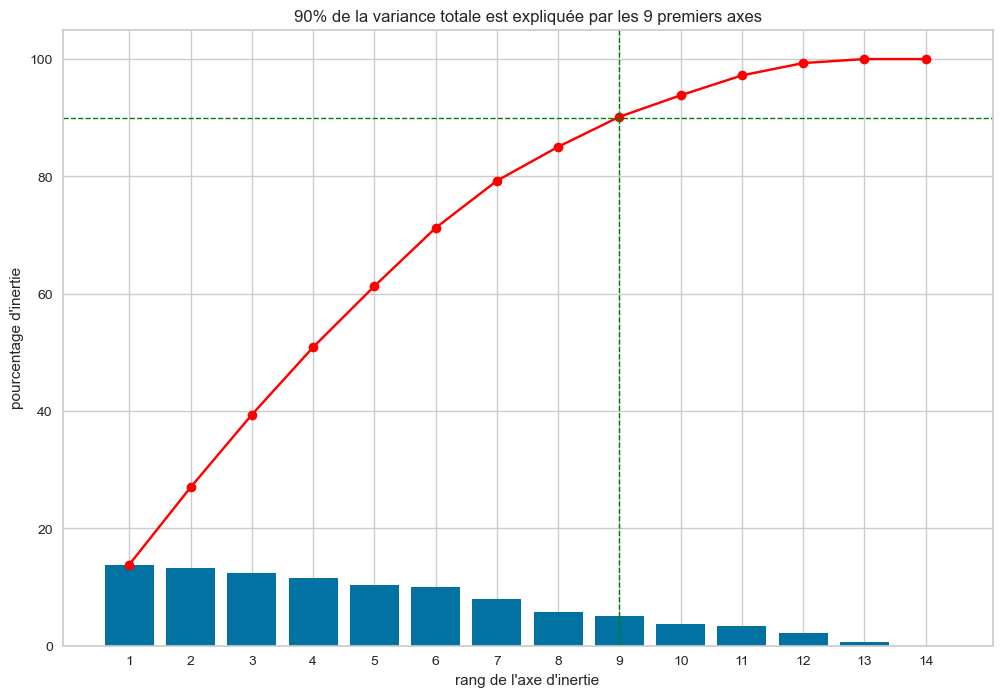

In [193]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [194]:
# 4 : Réduire la dimensionnalité des Données

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [195]:
import numpy as np
from sklearn.model_selection import train_test_split

In [196]:
 X_train, X_test,  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

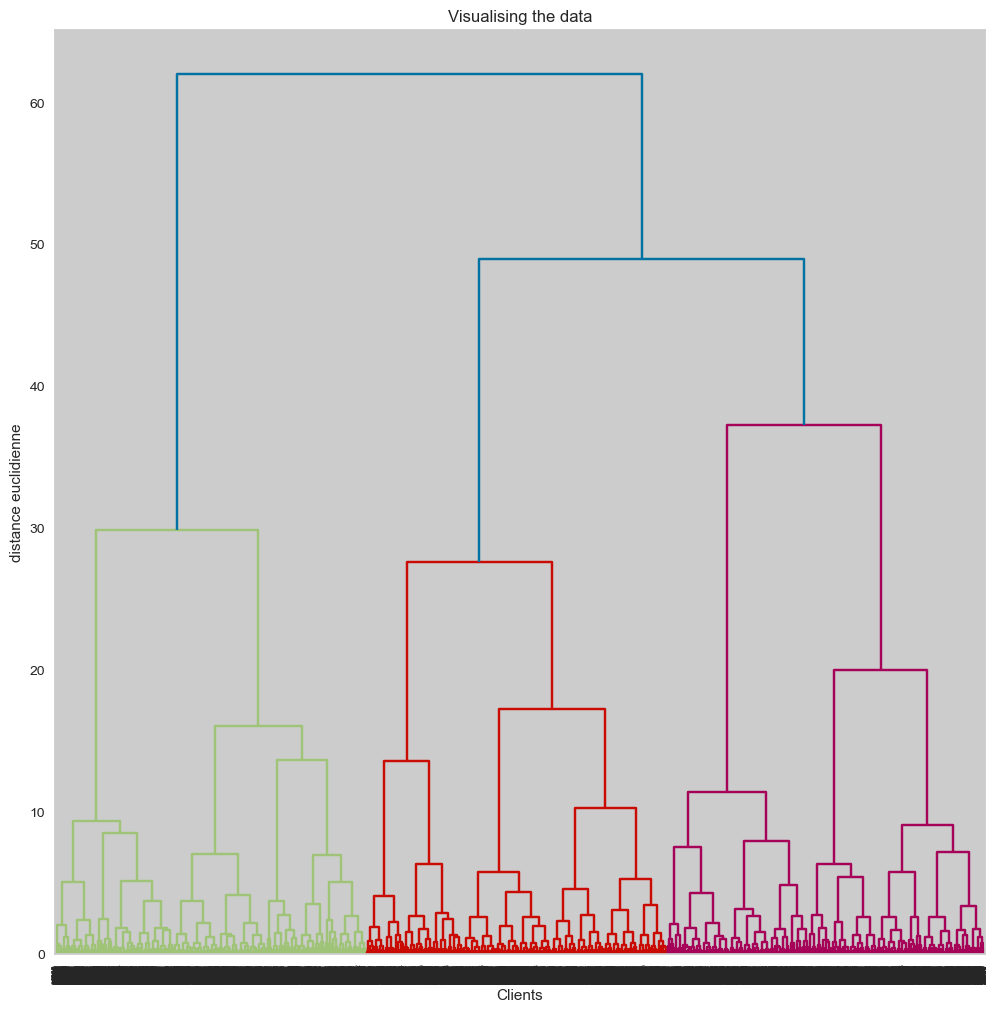

In [201]:
# Dendograms are used to divide a given cluster into many different clusters.

# Step 5: Visualizing the working of the Dendograms

plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
plt.xlabel('Clients')
plt.ylabel('distance euclidienne') 

Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))


In [202]:
 y_train, y_test,  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

## Clustering agglomératif

Dans le cas du clustering agglomératif (ou bottom-up), on commence par considérer que chaque point est un cluster à lui tout seul. Ensuite, on trouve les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points appartiennent à un seul cluster, constitué de l'agglomération de tous les clusters initiaux.

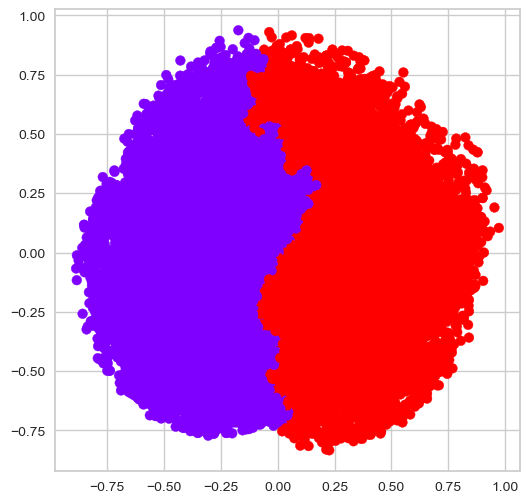

In [203]:
# Step 6: Building and Visualizing the different clustering models for different values of k
# k = 2

ac2 = AgglomerativeClustering(n_clusters = 2)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac2.fit_predict(y_test), cmap ='rainbow')
plt.show()

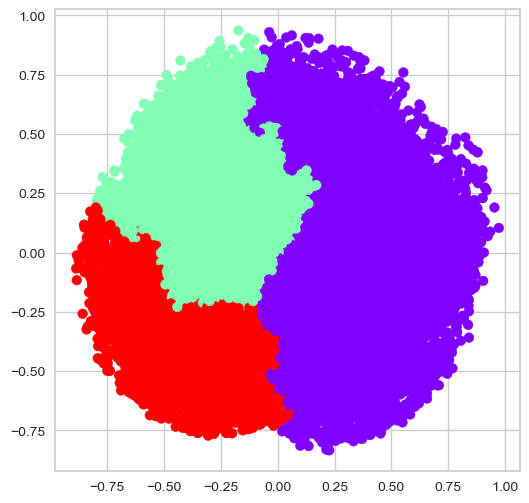

In [204]:
# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac3.fit_predict(y_test), cmap ='rainbow')
plt.show()

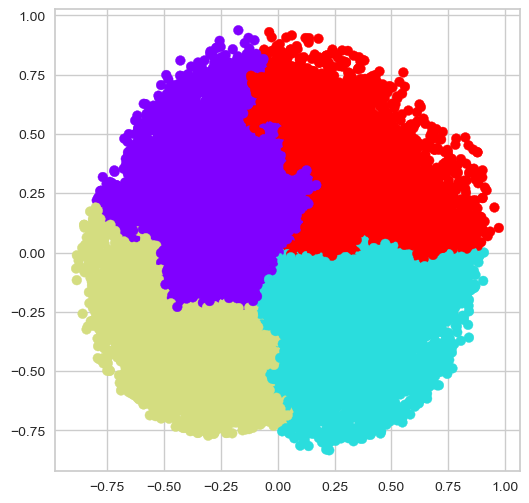

In [205]:
# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac4.fit_predict(y_test), cmap ='rainbow')
plt.show()

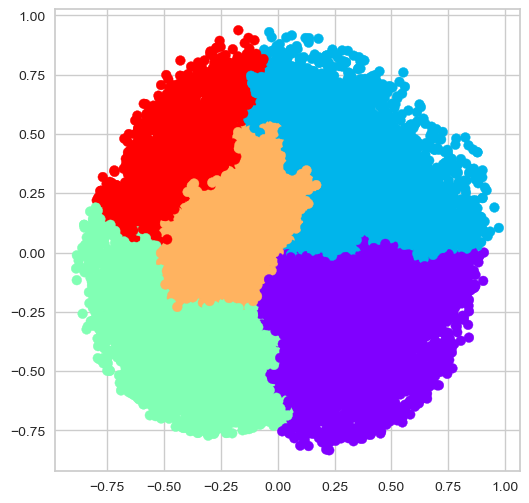

In [206]:
# k = 5

ac5 = AgglomerativeClustering(n_clusters = 5)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac5.fit_predict(y_test), cmap ='rainbow')
plt.show()

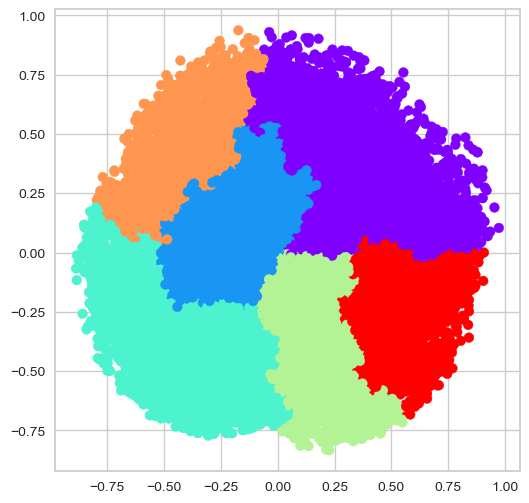

In [208]:
# k = 6

ac6 = AgglomerativeClustering(n_clusters = 6)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac6.fit_predict(y_test), cmap ='rainbow')
plt.show()

On va maintenant déterminer le nombre optimal de clusters en calculant le silhoutte score.

In [209]:
# Step 7: Evaluating the different models and Visualizing the results.

# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_test, ac2.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac3.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac4.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac5.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac6.fit_predict(y_test)))


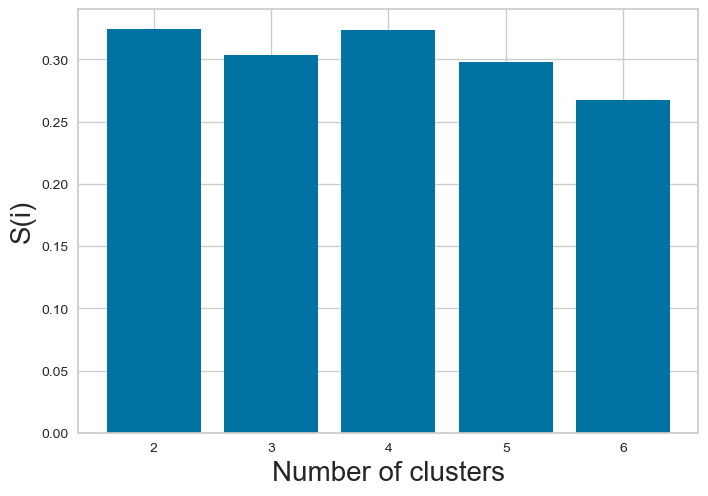

In [210]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

5 clusters semble raisonnable. 

In [211]:
Xbis_train,Xbis_test   = train_test_split(
                     X_normalized,  test_size=0.8, random_state=0)

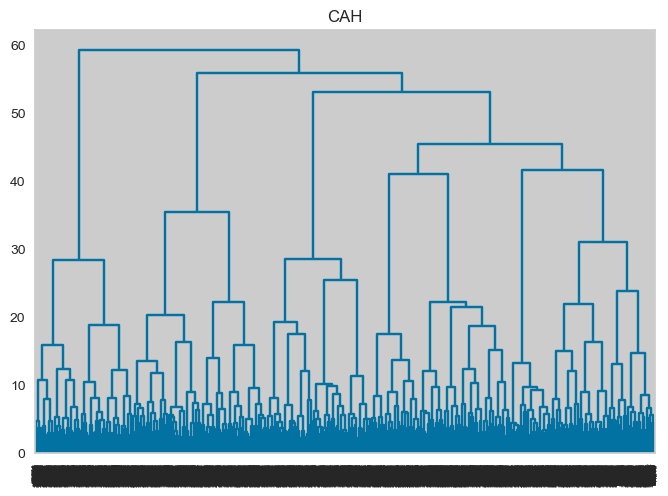

In [212]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(Xbis_train,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=Xbis_train.index,orientation='top',color_threshold=0)
plt.show()

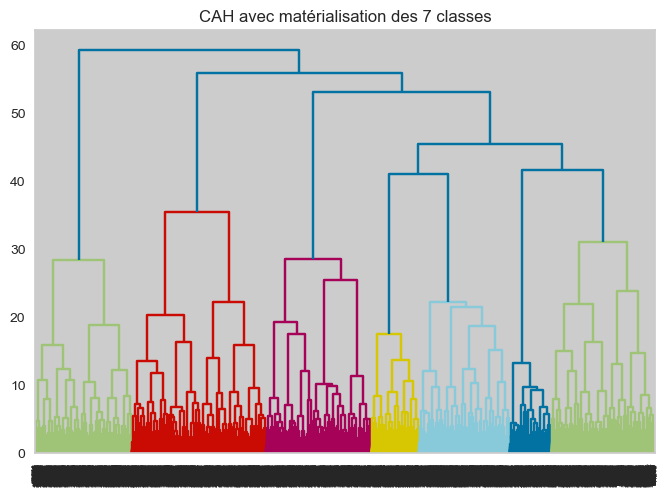

[2 4 5 ... 7 1 1]
         0
1    44503
1   102587
1    87114
1    29027
1    11944
..     ...
7    68429
7    10804
7     8830
7    12127
7    45973

[22948 rows x 1 columns]


In [214]:
from scipy.cluster.hierarchy import ward, fcluster
#matérialisation des 7 classes (hauteur t = 38
plt.title('CAH avec matérialisation des 7 classes')
dendrogram(Z,labels=Xbis_train.index,orientation='top',color_threshold=38)
plt.show()
#découpage à la hauteur t = 38==> identifiants de 6 groupes obtenus
groupes_cah = fcluster(Z,t=38,criterion='distance')
print(groupes_cah)
#index triés des groupes
idg = np.argsort(groupes_cah)
#affichage des observations et leurs groupes
print(pd.DataFrame(X_train.index[idg],groupes_cah[idg]))

In [215]:
Xbis_train = pd.DataFrame(Xbis_train, index=Xbis_train.index, columns=Xbis_train.columns)
Xbis_train_clusters = Xbis_train.mean()
Xbis_train_clusters

0    -0.024674
1    -0.025802
2    -0.026224
3    -0.025821
4     0.027775
5    -0.028803
6     0.001917
7     0.021047
8    -0.027683
9    -0.008850
10   -0.004552
11   -0.030690
12    0.000000
13    0.000739
dtype: float64

# DBSCAN Clustering

Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale. On peut le diviser en 4 étapes :

- On regarde le nombre de points à au plus une distance ε de celle-ci. On appelle cette zone le ε-voisinage de l’observation.
- Si une observation compte au moins un certain nombre de voisins y compris elle-même, elle est considérée comme une observation cœur. On a alors décelé une observation à haute densité.
- Toutes les observations au voisinage d’une observation cœur appartiennent au même cluster. Il peut y avoir des observations cœur proche les unes des autres. Par conséquent de proche en proche on obtient une longue séquence d’observations cœur qui constitue un unique cluster.
- Toute observation qui n’est pas une observation cœur et qui ne comporte pas d’observation cœur dans son voisinage est considérée comme une anomalie.


On a donc besoin de définir deux informations avant d’utiliser le DBSCAN :

Quelle distance ε pour déterminer pour chaque observation le ε-voisinage ? Quel est le nombre minimal de voisins nécessaire pour considérer qu’une observation est une observation cœur ?

In [216]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
labels = db_default.labels_

In [217]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [218]:
# Step 5: Building the clustering model
from sklearn import metrics
labels_true = X.index
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 6
Estimated number of noise points: 32
Homogeneity: 0.0005
Completeness: 1.0000
V-measure: 0.0010
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: 0.0000
Silhouette Coefficient: -0.6354


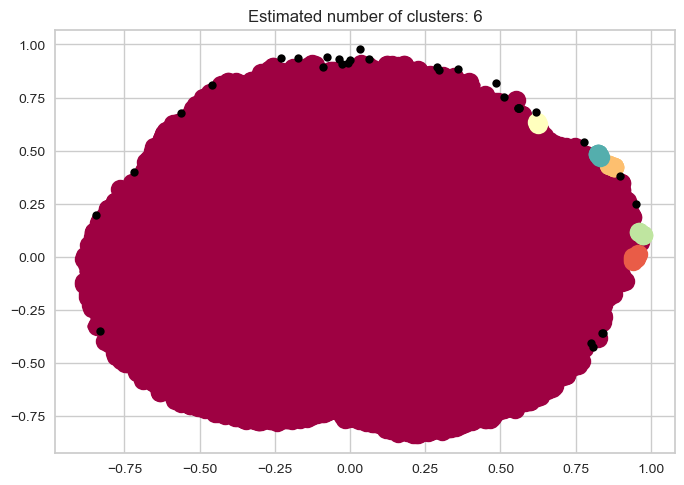

In [219]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_principal[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_principal[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## DBSCAN clustering sur les données sans ACP

In [220]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.405, min_samples = 5).fit(X_normalized)
labels = db_default.labels_

In [221]:
np.unique(labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [222]:
# Step 5: Building the clustering model
from sklearn import metrics
labels_true = X.index
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.405, min_samples = 5).fit(X_normalized)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 205
Estimated number of noise points: 1331
Homogeneity: 0.0183
Completeness: 1.0000
V-measure: 0.0359
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: 0.0000
Silhouette Coefficient: -0.9422


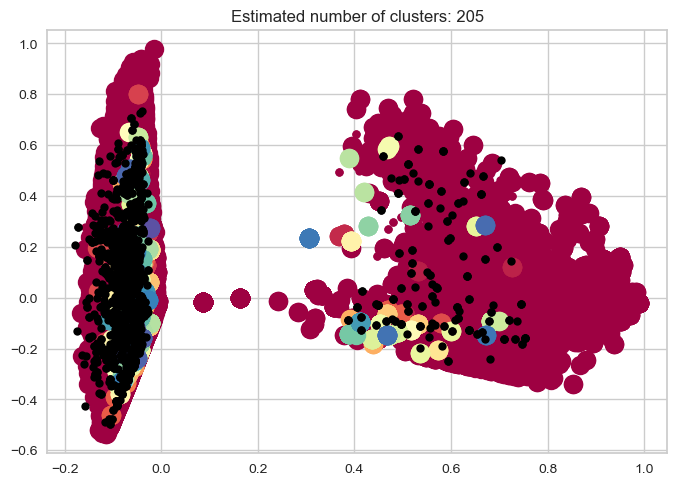

In [223]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_normalized[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_normalized[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Conclusions

En conclusion on a partitionné notre datasets clients en utilisant diffents algorithmes dont K-Means,clustering hierarchique, agglomerative clustering selon Ward, et DBSCAN, les resultas malgré certainnes imperfections tournent autour de 5 à 7 clusters ,mais le plus probants quant au score (silhouette), fit-time,ainsi que son score à l'initialisation est le modele K-Means dont on garde les resultats.

Quant à la maintenance, il faudra donc prévoir celle du programme de segmentation tous les 6 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner, en veillant à redéfinir les segments clients à chaque maintenance.